# Preparation

Importing libraries

In [ ]:
pip install grad-cam thop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [ ]:
import numpy as np
import torch
import torchvision
import sklearn

import time
from datetime import datetime
import  matplotlib.pyplot as plt

from google.colab import files
from sklearn import metrics
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from thop import profile, clever_format

Download and unzip dataset and model

In [ ]:
#Dataset
!gdown https://drive.google.com/uc?id=1TOiNfQdH8GVWcNBC9v_YktuwXCbdLuq-
!unzip /content/fer2013.zip
#Models
!gdown https://drive.google.com/uc?id=1DFo9738zbmV1MJ2h5tQzO3BEk-Iulf4i
!unzip /content/models.zip

Streaming output truncated to the last 5000 lines.
 extracting: fer2013/train/sad/Training_65505359.jpg  
 extracting: fer2013/train/sad/Training_65508578.jpg  
 extracting: fer2013/train/sad/Training_65516023.jpg  
 extracting: fer2013/train/sad/Training_65524027.jpg  
 extracting: fer2013/train/sad/Training_65526454.jpg  
 extracting: fer2013/train/sad/Training_65531175.jpg  
 extracting: fer2013/train/sad/Training_65552921.jpg  
 extracting: fer2013/train/sad/Training_65552938.jpg  
 extracting: fer2013/train/sad/Training_65563105.jpg  
 extracting: fer2013/train/sad/Training_6558295.jpg  
 extracting: fer2013/train/sad/Training_65586139.jpg  
 extracting: fer2013/train/sad/Training_65591252.jpg  
 extracting: fer2013/train/sad/Training_65626778.jpg  
 extracting: fer2013/train/sad/Training_65701260.jpg  
 extracting: fer2013/train/sad/Training_65707197.jpg  
 extracting: fer2013/train/sad/Training_65720898.jpg  
 extracting: fer2013/train/sad/Training_6573454.jpg  
 extracting: fer

### Define functions that will be used repeatedly

In [ ]:
def setup_transformation(resize, crop, mean, std):
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size = resize),
        torchvision.transforms.CenterCrop(size = crop),
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomRotation(degrees=(-30, 30)),
        torchvision.transforms.RandomErasing(p=0.10)
    ])

    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size = resize),
        torchvision.transforms.CenterCrop(size = crop),
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)
    ])

    invnorm_transform = torchvision.transforms.Compose([
        torchvision.transforms.Normalize((0., 0., 0.), (1/std[0], 1/std[1], 1/std[2])),
        torchvision.transforms.Normalize((-mean[0], -mean[1], -mean[2]), (1., 1., 1.)),
    ])

    return train_transform, test_transform, invnorm_transform

def load_data(data_dir, train_transform, test_transform, batch_size, num_workers):
    train = torchvision.datasets.ImageFolder(root= data_dir + "/train", transform = train_transform)
    test = torchvision.datasets.ImageFolder(root= data_dir + "/test", transform = test_transform)

    bootstrap = torch.utils.data.RandomSampler(train, replacement = True)
    test, val = torch.utils.data.random_split(test, [0.5, 0.5], generator=torch.Generator().manual_seed(15))

    train_loader = torch.utils.data.DataLoader(
        train,
        batch_size=batch_size,
        num_workers=num_workers,
        sampler = bootstrap,
#         shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        val,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )

    test_loader = torch.utils.data.DataLoader(
        test,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )

    return train, val, test, train_loader, val_loader, test_loader

def build_model(arch):
    num_classes = len(labels_map)

    if "efficient_net_b1" in arch:
        ori_net = torchvision.models.efficientnet_b1(weights = "DEFAULT")
        model = CustomEfficientNet(num_classes = num_classes, ori_net = ori_net)

    elif "shuffle" in arch:
        ori_net = torchvision.models.shufflenet_v2_x2_0(weights = "DEFAULT")
        model = CustomShuffleNet(num_classes = num_classes, ori_net = ori_net)

    elif "mobile" in arch:
        ori_net = torchvision.models.mobilenet_v3_large(weights = "DEFAULT")
        model = CustomMobileNet(num_classes = num_classes, ori_net = ori_net)

    elif "squeeze" in arch:
        ori_net = torchvision.models.squeezenet1_1(weights = "DEFAULT")
        model = CustomSqueezeNet(num_classes = num_classes, ori_net = ori_net)

    elif "vit" in arch:
        ori_net = torchvision.models.vit_l_32(weights = "DEFAULT")
        model = CustomVit(num_classes = num_classes, ori_net = ori_net)

    elif "efficient_net_b3" in arch:
        ori_net = torchvision.models.efficientnet_b3(weights = "DEFAULT")
        model = CustomEfficientNet(num_classes = num_classes, ori_net = ori_net)

    return model

class EarlyStopping:
    def __init__(self, tolerance=7, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, best_acc, epoch_val_acc):
        if epoch_val_acc > (best_acc + self.min_delta):
            self.counter = 0
        elif epoch_val_acc < (best_acc + self.min_delta):
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

def train_model(model_ft, criterion, optimizer, scheduler, early_stopping, train_loader, val_loader, num_epochs=15, binary = None):
    since = time.time()
    best_model_wts = model_ft.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Training Epoch {}/{}'.format(epoch+1, num_epochs+1 - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0
        count = 0
        model_ft.train(True)
        dset_sizes = len(train)

        for data in train_loader:
            inputs, labels = data
            if binary is not None:
                labels = torch.tensor([1 if i.item() == binary else 0 for i in labels])
            labels = torch.squeeze(labels.type(torch.LongTensor))
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)

            outputs = model_ft(inputs)

            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            count += 1
            if count % 100 == 0 or outputs.size()[0] < batch_size:
                print('Epoch {}: loss:{:.3f}'.format(epoch+1, loss.item()))

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dset_sizes
        epoch_acc = running_corrects.double() / dset_sizes

        running_val_loss = 0.0
        running_val_corrects = 0
        count_val = 0
        model_ft.eval()
        dset_sizes = len(val)

        for data in val_loader:
            inputs, labels = data
            if binary is not None:
                labels = torch.tensor([1 if i.item() == binary else 0 for i in labels])
            labels = torch.squeeze(labels.type(torch.LongTensor))
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model_ft(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            running_val_corrects += torch.sum(preds == labels.data)
            count_val += 1

        epoch_val_loss = running_val_loss / dset_sizes
        epoch_val_acc = running_val_corrects.double() / dset_sizes

        print('Train loss: {:.4f}, Train Acc: {:.4f}, Val loss: {:.4f}, Val Acc: {:.4f}'.format(epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc))

        scheduler.step(epoch_val_acc)

        early_stopping(best_acc, epoch_val_acc)
        if early_stopping.early_stop:
          print("Early stopping at epoch:", epoch+1)
          break

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = model_ft.state_dict()
        if epoch_val_acc > 0.999:
            break

    # save best model
    save_dir = data_dir
    model_ft.load_state_dict(best_model_wts)
    stamp = datetime.today().strftime('%Y%m%d_%H%M')
    model_out_path = save_dir + mod_name + '_' + stamp + '.pth'
    torch.save(model_ft, model_out_path)
    files.download(model_out_path)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return best_model_wts

def test_model(model, criterion, test, test_loader, binary = None, conf = False):
    dset_sizes = len(test)
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    cont = 0
    outPre = []
    outLabel = []
    for data in test_loader:
        inputs, labels = data
        if binary is not None:
            labels = torch.tensor([1 if i.item() == binary else 0 for i in labels])
        labels = torch.squeeze(labels.type(torch.LongTensor))
        if torch.cuda.is_available():
          inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        confs = torch.nn.functional.softmax(outputs, dim=1)
        prob, _ = torch.max(confs.data, 1)
        loss = criterion(outputs, labels)
        if cont == 0:
            outPre = preds.data.cpu()
            outLabel = labels.data.cpu()
            if conf:
                probs = prob.cpu()
        else:
            outPre = torch.cat((outPre, preds.data.cpu()), 0)
            outLabel = torch.cat((outLabel, labels.data.cpu()), 0)
            if conf:
                probs = torch.cat((probs, prob.cpu()), 0)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        cont += 1
    print('Loss: {:.4f} Acc: {:.4f}'.format(running_loss / dset_sizes,
                                            running_corrects.double() / dset_sizes))

    if conf:
        return outPre, outLabel, probs
    return outPre, outLabel

def create_gradCAM(trained_model_path, img, image_weight = 0.6):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = torch.load((trained_model_path),
                       map_location=torch.device(device)
                       )

    if "efficient" in trained_model_path:
        target_layers = model.features[-1]
    elif "shuffle" in trained_model_path:
        target_layers = model.features[-1]
    elif "mobile" in trained_model_path:
        target_layers = model.features[-2][-1]
    elif "squeeze" in trained_model_path:
        target_layers = model.features[-1]
    elif "vit" in trained_model_path:
        target_layers = model.features[-1]

    model.eval()
    input_tensor = img.unsqueeze(0)
    input_tensor = input_tensor.to(device)

    pred = torch.argmax(model(input_tensor), 1)
    targets = [ClassifierOutputTarget(pred.item())]

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]

    x = img.detach().cpu().numpy()
    x_norm = (x-np.min(x))/(np.max(x)-np.min(x))
    visualization = show_cam_on_image(x_norm.transpose((1, 2, 0)), grayscale_cam, use_rgb=True, image_weight = image_weight)

    return visualization, pred

# create custom SqueezeNet
class CustomSqueezeNet(torch.nn.Module):
    def __init__(self, num_classes, ori_net):
        super(CustomSqueezeNet, self).__init__()
        self.features = torch.nn.Sequential(*list(ori_net.children())[:-1])
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            torch.nn.Conv2d(512, num_classes, kernel_size=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x,1)

# create custom MobileNet
class CustomMobileNet(torch.nn.Module):
    def __init__(self, num_classes, ori_net):
        super(CustomMobileNet, self).__init__()
        self.features = torch.nn.Sequential(*list(ori_net.children())[:-1])
        self.classifier = torch.nn.Sequential(
            *list(ori_net.classifier.children())[:-1],
            torch.nn.Linear(1280, num_classes, bias = True),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

# create custom ShuffleNet
class CustomShuffleNet(torch.nn.Module):
    def __init__(self, num_classes, ori_net):
        super(CustomShuffleNet, self).__init__()
        self.features = torch.nn.Sequential(*list(ori_net.children())[:-1])
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(2048, num_classes, bias = True),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

Define global variables

In [ ]:
num_workers = 2
batch_size = 48
mean = [0.5075, 0.5075, 0.5075]
std = [0.2121, 0.2121, 0.2121]
data_dir = "/content/fer2013"
# data_dir = "D:/Downloads/fer2013"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

labels_map = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}

num_classes = len(labels_map)

# Backbone Smaller Models

## EfficientNet Experiment

Define custom model class

In [ ]:
# create custom efficientnet
class CustomEfficientNet(torch.nn.Module):
    def __init__(self, num_classes, ori_net):
        super(CustomEfficientNet, self).__init__()
        self.features = torch.nn.Sequential(*list(ori_net.features.children()))
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.classifier = torch.nn.Sequential(
            *[list(ori_net.classifier.children())[i] for i in [0]],
            torch.nn.Linear(1280, num_classes, bias = True),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x


mod_name = '/efficient_net_b1'
model = build_model(mod_name)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:03<00:00, 9.39MB/s]


Load data

In [ ]:
resize = 255
crop = 240

train_transform, test_transform, invnorm_transform = setup_transformation(resize = resize,
                                                                          crop = crop,
                                                                          mean = mean,
                                                                          std = std)

train, val, test, train_loader, val_loader, test_loader = load_data(data_dir,
                                                                    train_transform,
                                                                    test_transform,
                                                                    batch_size,
                                                                    num_workers)

In [ ]:
input = torch.randn(1, 3, crop, crop)
macs, params = profile(model, inputs=(input, ))
macs, params = clever_format([macs, params], "%.3f")
print(macs, params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
733.215M 6.522M


Plot image examples

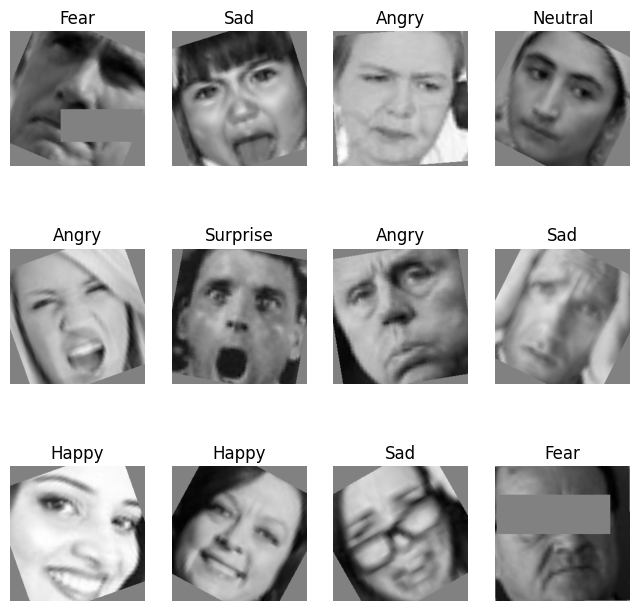

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train), size=(1,)).item()
    img, label = train[sample_idx]
    img = invnorm_transform(img)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

Retrain model from scratch (using pre-trained weights for initialization point)

In [ ]:
lr = 0.0001
label_smoothing = 0.1
weight_decay=0.001
num_epochs = 15

early_stopping = EarlyStopping(tolerance=15, min_delta=0)

criterion = torch.nn.CrossEntropyLoss(label_smoothing = label_smoothing)

optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay=weight_decay,
                            )


if torch.cuda.is_available():
    model, criterion = model.cuda(), criterion.cuda()

best_model = train_model(model, criterion, optimizer,train_loader, val_loader, num_epochs=num_epochs)

Training Epoch 1/15
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: loss:1.748
Epoch 1: loss:1.599
Epoch 1: loss:1.515
Epoch 1: loss:1.344
Epoch 1: loss:1.422
Epoch 1: loss:1.216
Train loss: 1.5190, Train Acc: 0.4563, Val loss: 1.2961, Val Acc: 0.5818
Training Epoch 2/15
----------
Epoch 2: loss:1.309
Epoch 2: loss:1.220
Epoch 2: loss:1.293
Epoch 2: loss:1.423
Epoch 2: loss:1.144
Epoch 2: loss:1.384
Train loss: 1.2780, Train Acc: 0.5876, Val loss: 1.2067, Val Acc: 0.6264
Training Epoch 3/15
----------
Epoch 3: loss:1.164
Epoch 3: loss:1.258
Epoch 3: loss:1.143
Epoch 3: loss:1.305
Epoch 3: loss:1.052
Epoch 3: loss:1.119
Train loss: 1.2001, Train Acc: 0.6308, Val loss: 1.2001, Val Acc: 0.6300
Training Epoch 4/15
----------
Epoch 4: loss:1.292
Epoch 4: loss:1.025
Epoch 4: loss:1.162
Epoch 4: loss:1.076
Epoch 4: loss:1.034
Epoch 4: loss:1.548
Train loss: 1.1650, Train Acc: 0.6500, Val loss: 1.1618, Val Acc: 0.6548
Training Epoch 5/15
----------
Epoch 5: loss:1.083
Epoch 5: loss:1.108
Epoch 5: loss:1.004
Epoch 5: loss:1.165
Epoch 5: loss:1.264
Epoc

Evaluate on test subset

In [ ]:
trained_model_path = "/content/efficient_net_b1_20240429_0910.pth"
# trained_model_path = "D:/Downloads/model/efficient_net_b1_20240429_0910.pth"

print('-' * 10)
print('Test Accuracy:')

model = torch.load(trained_model_path,
                   map_location=torch.device(device)
                   )
criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()
outPre, outLabel = test_model(model, criterion, test, test_loader)

----------
Test Accuracy:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss: 0.9693 Acc: 0.6776


Confusion Matrix

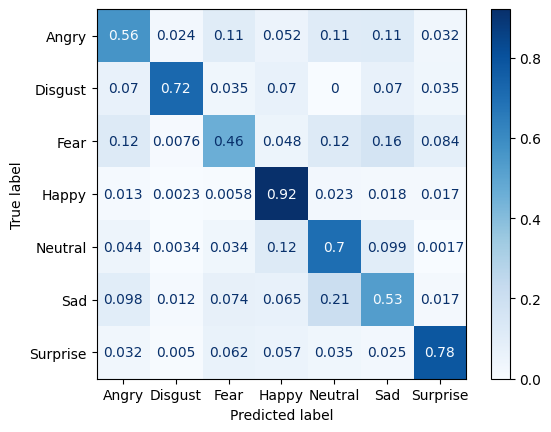

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel, outPre, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report

In [ ]:
report = sklearn.metrics.classification_report(outLabel,
                                               outPre,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.61      0.56      0.58       497
     Disgust       0.58      0.72      0.64        57
        Fear       0.61      0.46      0.53       526
       Happy       0.81      0.92      0.86       869
     Neutral       0.60      0.70      0.64       593
         Sad       0.59      0.53      0.56       645
    Surprise       0.78      0.78      0.78       402

    accuracy                           0.68      3589
   macro avg       0.65      0.67      0.66      3589
weighted avg       0.67      0.68      0.67      3589



GradCAM Analysis

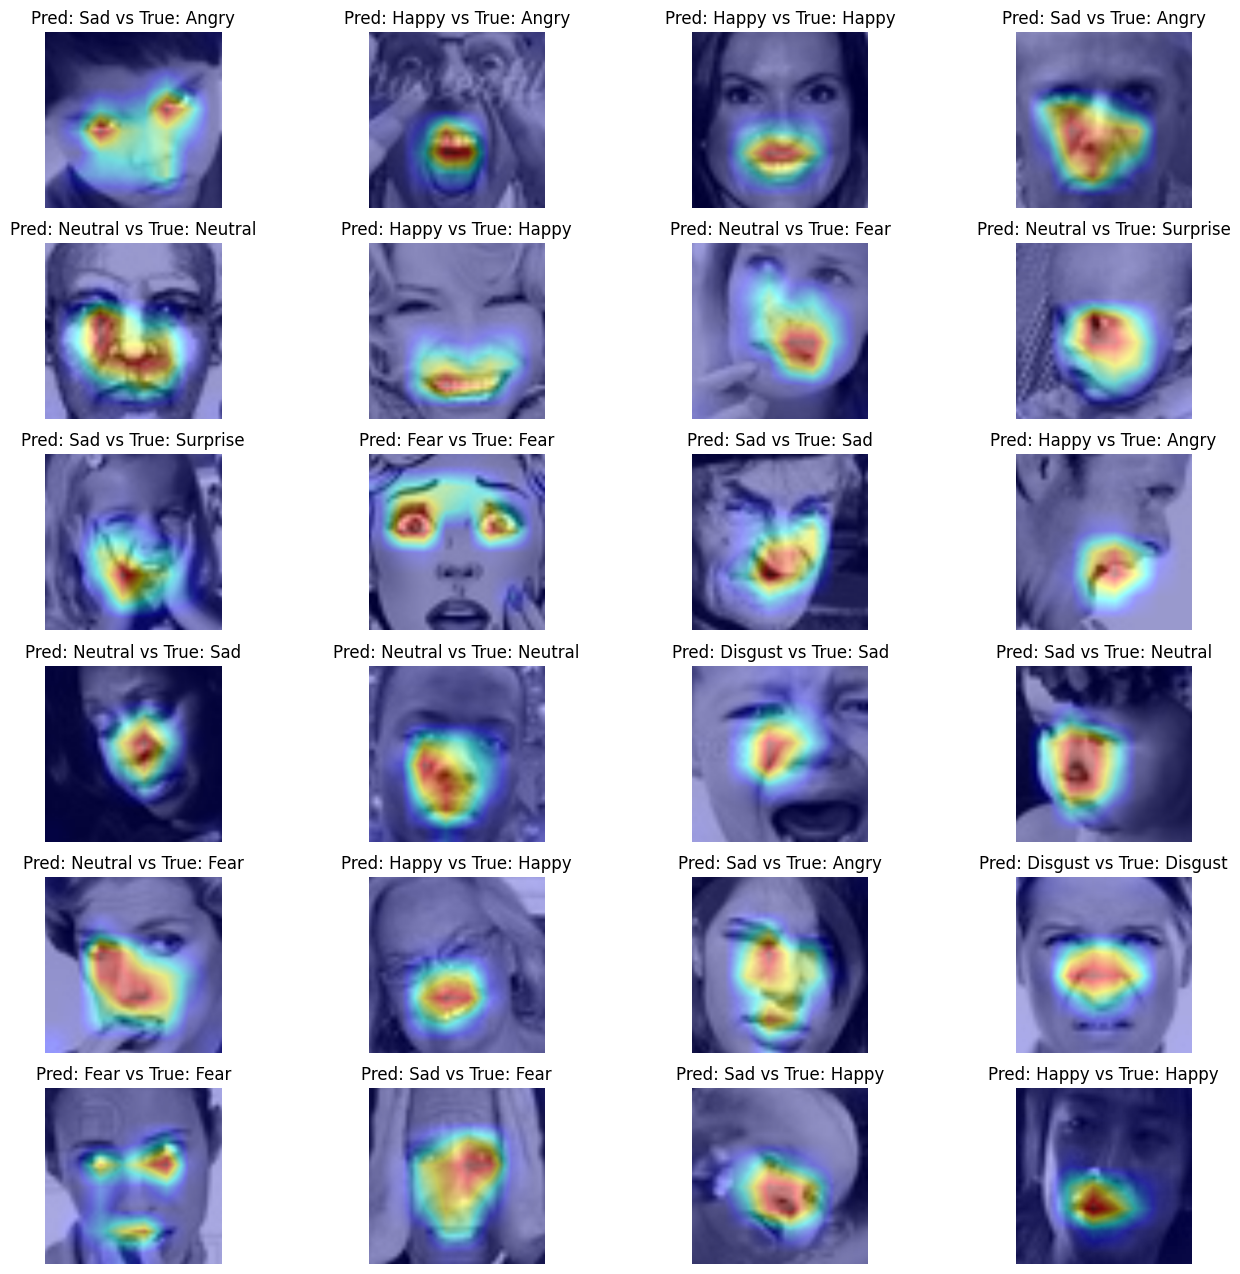

In [ ]:
figure = plt.figure(figsize=(16, 16))
cols, rows = 4, 6

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test), size=(1,)).item()
    img, label = test[sample_idx]
    img = invnorm_transform(img)
    viz, pred = create_gradCAM(trained_model_path, img)

    figure.add_subplot(rows, cols, i)
    plt.imshow(viz)
    plt.title("Pred: {} vs True: {}".format(labels_map[pred.item()], labels_map[label]))
    plt.axis("off")
plt.show()

## ShuffleNet Experiment

Define custom model class

In [ ]:
# create custom ShuffleNet
class CustomShuffleNet(torch.nn.Module):
    def __init__(self, num_classes, ori_net):
        super(CustomShuffleNet, self).__init__()
        self.features = torch.nn.Sequential(*list(ori_net.children())[:-1])
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(2048, num_classes, bias = True),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

mod_name = '/shuffle_net_v2_x2_0'
model = build_model(mod_name)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:04<00:00, 6.79MB/s]


Load data

In [ ]:
resize = 232
crop = 224

train_transform, test_transform, invnorm_transform = setup_transformation(resize = resize,
                                                                          crop = crop,
                                                                          mean = mean,
                                                                          std = std)

train, val, test, train_loader, val_loader, test_loader = load_data(data_dir,
                                                                    train_transform,
                                                                    test_transform,
                                                                    batch_size,
                                                                    num_workers)

In [ ]:
input = torch.randn(1, 3, crop, crop)
macs, params = profile(model, inputs=(input, ))
macs, params = clever_format([macs, params], "%.3f")
print(macs, params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
596.196M 5.359M


Retrain model from scratch (Using pre-trained weights as initialization point)

In [ ]:
lr = 0.0001
label_smoothing = 0.1
weight_decay=0.01
num_epochs = 15

early_stopping = EarlyStopping(tolerance=15, min_delta=0)

criterion = torch.nn.CrossEntropyLoss(label_smoothing = label_smoothing)

optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay=weight_decay,
                            )

if torch.cuda.is_available():
    model, criterion = model.cuda(), criterion.cuda()

best_model = train_model(model, criterion, optimizer,train_loader, val_loader, num_epochs=num_epochs)

Training Epoch 1/15
----------
Epoch 1: loss:1.675
Epoch 1: loss:1.474
Epoch 1: loss:1.596
Epoch 1: loss:1.417
Epoch 1: loss:1.212
Epoch 1: loss:1.436
Train loss: 1.4668, Train Acc: 0.4888, Val loss: 1.3736, Val Acc: 0.5840
Training Epoch 2/15
----------
Epoch 2: loss:1.339
Epoch 2: loss:1.393
Epoch 2: loss:1.173
Epoch 2: loss:1.219
Epoch 2: loss:1.284
Epoch 2: loss:1.421
Train loss: 1.2284, Train Acc: 0.6197, Val loss: 1.3627, Val Acc: 0.5999
Training Epoch 3/15
----------
Epoch 3: loss:1.233
Epoch 3: loss:1.191
Epoch 3: loss:1.306
Epoch 3: loss:1.065
Epoch 3: loss:1.237
Epoch 3: loss:1.486
Train loss: 1.1706, Train Acc: 0.6495, Val loss: 1.2438, Val Acc: 0.6225
Training Epoch 4/15
----------
Epoch 4: loss:1.080
Epoch 4: loss:1.182
Epoch 4: loss:1.151
Epoch 4: loss:1.099
Epoch 4: loss:1.088
Epoch 4: loss:1.768
Train loss: 1.1407, Train Acc: 0.6644, Val loss: 1.2195, Val Acc: 0.6417
Training Epoch 5/15
----------
Epoch 5: loss:1.192
Epoch 5: loss:1.149
Epoch 5: loss:1.024
Epoch 5: loss

Evaluate on test subset

In [ ]:
trained_model_path = "/content/shuffle_net_v2_x2_0_20240429_0946.pth"
# trained_model_path = "D:/Downloads/model/shuffle_net_v2_x2_0_20240429_0946.pth"

print('-' * 10)
print('Test Accuracy:')

model = torch.load(trained_model_path,
                   map_location=torch.device(device)
                   )
criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()
outPre, outLabel = test_model(model, criterion, test, test_loader)

----------
Test Accuracy:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss: 0.9642 Acc: 0.6570


Confusion Matrix

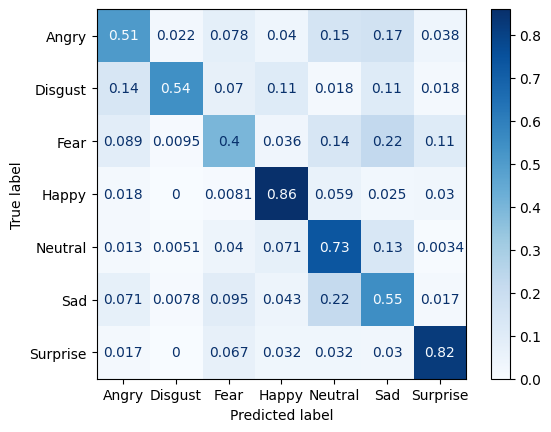

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel, outPre, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report

In [ ]:
report = sklearn.metrics.classification_report(outLabel,
                                               outPre,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.66      0.51      0.57       497
     Disgust       0.56      0.54      0.55        57
        Fear       0.56      0.40      0.47       526
       Happy       0.85      0.86      0.86       869
     Neutral       0.55      0.73      0.63       593
         Sad       0.53      0.55      0.54       645
    Surprise       0.74      0.82      0.78       402

    accuracy                           0.66      3589
   macro avg       0.64      0.63      0.63      3589
weighted avg       0.66      0.66      0.65      3589



GradCAM Analysis

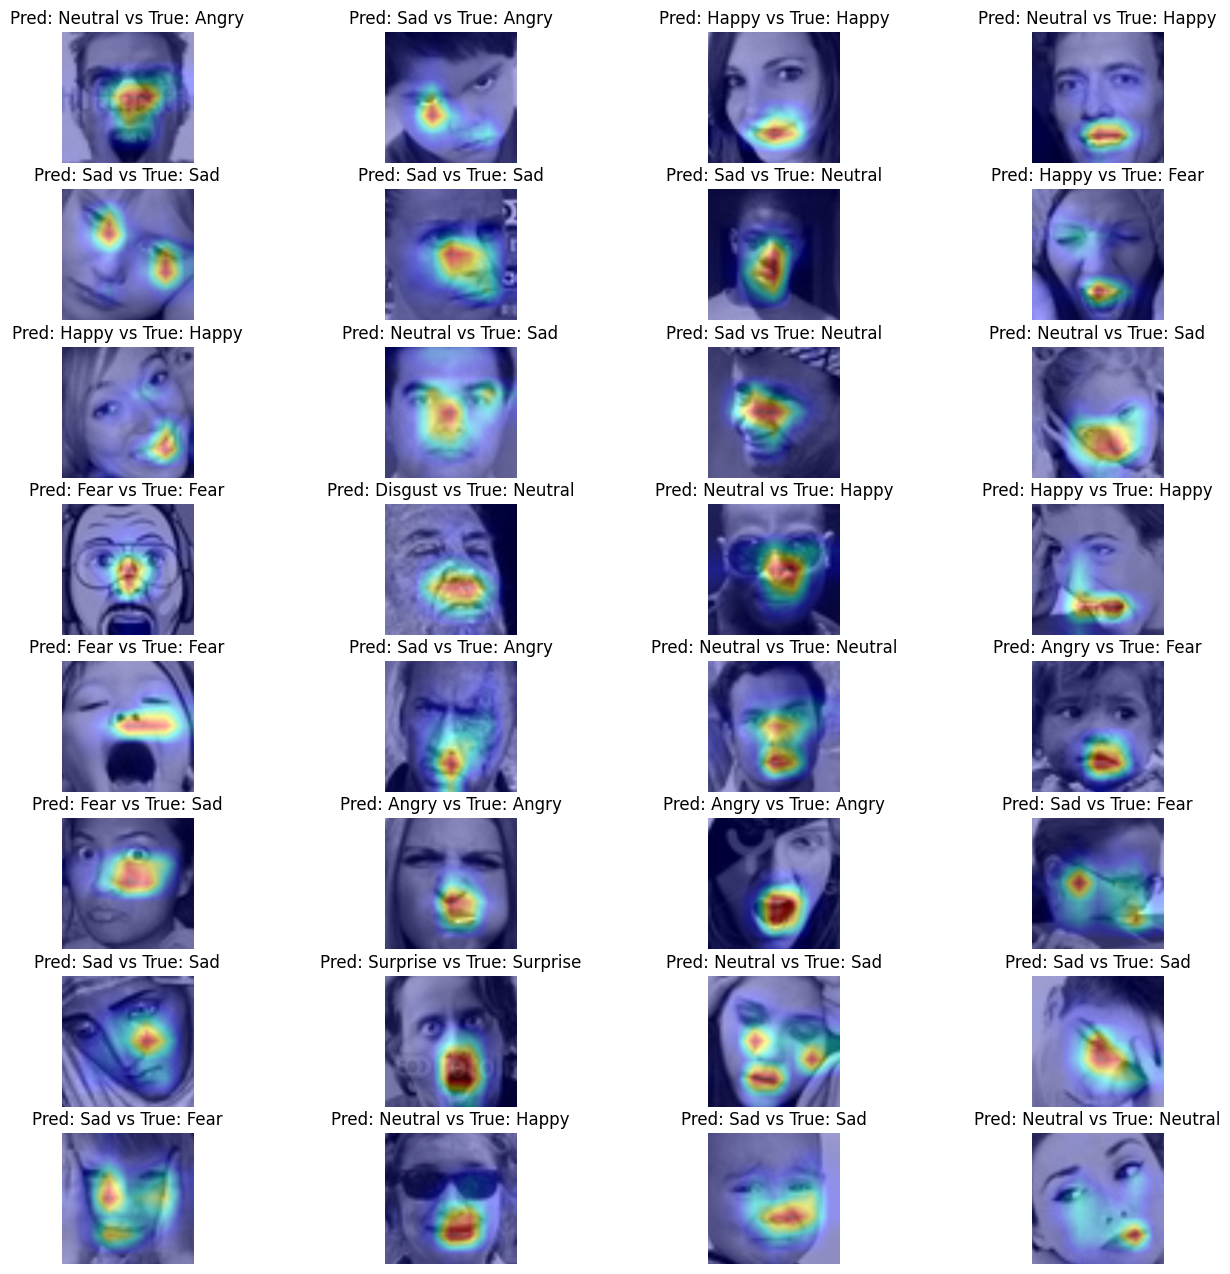

In [ ]:
figure = plt.figure(figsize=(16, 16))
cols, rows = 4, 8

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test), size=(1,)).item()
    img, label = test[sample_idx]
    img = invnorm_transform(img)
    viz, pred = create_gradCAM(trained_model_path, img)

    figure.add_subplot(rows, cols, i)
    plt.imshow(viz)
    plt.title("Pred: {} vs True: {}".format(labels_map[pred.item()], labels_map[label]))
    plt.axis("off")
plt.show()

## MobileNet Experiment

Define custom model class

In [ ]:
# create custom MobileNet
class CustomMobileNet(torch.nn.Module):
    def __init__(self, num_classes, ori_net):
        super(CustomMobileNet, self).__init__()
        self.features = torch.nn.Sequential(*list(ori_net.children())[:-1])
        self.classifier = torch.nn.Sequential(
            *list(ori_net.classifier.children())[:-1],
            torch.nn.Linear(1280, num_classes, bias = True),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

mod_name = '/mobile_net_v3l'
model = build_model(mod_name)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 168MB/s]


Load data

In [ ]:
resize = 232
crop = 224

train_transform, test_transform, invnorm_transform = setup_transformation(resize = resize,
                                                                          crop = crop,
                                                                          mean = mean,
                                                                          std = std)

train, val, test, train_loader, val_loader, test_loader = load_data(data_dir,
                                                                    train_transform,
                                                                    test_transform,
                                                                    batch_size,
                                                                    num_workers)

In [ ]:
input = torch.randn(1, 3, crop, crop)
macs, params = profile(model, inputs=(input, ))
macs, params = clever_format([macs, params], "%.3f")
print(macs, params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
233.567M 4.211M


Retrain model from scratch (Using pre-trained weights as initialization point)

In [ ]:
lr = 0.00005
label_smoothing = 0.1
weight_decay=0.005
num_epochs = 15

early_stopping = EarlyStopping(tolerance=15, min_delta=0)

criterion = torch.nn.CrossEntropyLoss(label_smoothing = label_smoothing)

optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay=weight_decay,
                            )

if torch.cuda.is_available():
    model, criterion = model.cuda(), criterion.cuda()

best_model = train_model(model, criterion, optimizer,train_loader, val_loader, num_epochs=num_epochs)

Training Epoch 1/15
----------
Epoch 1: loss:1.749
Epoch 1: loss:1.611
Epoch 1: loss:1.546
Epoch 1: loss:1.471
Epoch 1: loss:1.394
Epoch 1: loss:1.317
Train loss: 1.5747, Train Acc: 0.4261, Val loss: 1.4775, Val Acc: 0.5143
Training Epoch 2/15
----------
Epoch 2: loss:1.246
Epoch 2: loss:1.262
Epoch 2: loss:1.206
Epoch 2: loss:1.391
Epoch 2: loss:1.228
Epoch 2: loss:1.535
Train loss: 1.3328, Train Acc: 0.5607, Val loss: 1.3109, Val Acc: 0.5676
Training Epoch 3/15
----------
Epoch 3: loss:1.214
Epoch 3: loss:1.441
Epoch 3: loss:1.443
Epoch 3: loss:1.204
Epoch 3: loss:0.937
Epoch 3: loss:2.025
Train loss: 1.2592, Train Acc: 0.5968, Val loss: 1.2554, Val Acc: 0.6077
Training Epoch 4/15
----------
Epoch 4: loss:1.052
Epoch 4: loss:1.314
Epoch 4: loss:1.150
Epoch 4: loss:1.427
Epoch 4: loss:1.209
Epoch 4: loss:1.497
Train loss: 1.2062, Train Acc: 0.6260, Val loss: 1.2347, Val Acc: 0.6094
Training Epoch 5/15
----------
Epoch 5: loss:1.300
Epoch 5: loss:1.141
Epoch 5: loss:1.107
Epoch 5: loss

Evaluate on test subset

In [ ]:
trained_model_path = "/content/mobile_net_v3l_20240429_1217.pth"
# trained_model_path = "D:/Downloads/model/mobile_net_v3l_20240429_1217.pth"

print('-' * 10)
print('Test Accuracy:')

model = torch.load(trained_model_path,
                   map_location=torch.device(device)
                   )
criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()
outPre, outLabel = test_model(model, criterion, test, test_loader)

----------
Test Accuracy:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss: 0.9967 Acc: 0.6495


Confusion Matrix

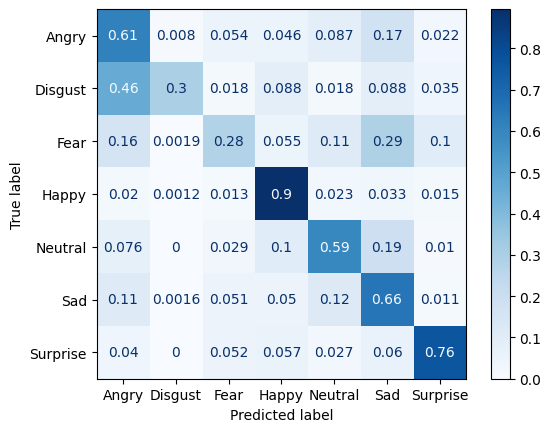

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel, outPre, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report

In [ ]:
report = sklearn.metrics.classification_report(outLabel,
                                               outPre,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.54      0.61      0.58       497
     Disgust       0.71      0.30      0.42        57
        Fear       0.58      0.28      0.38       526
       Happy       0.82      0.90      0.85       869
     Neutral       0.63      0.59      0.61       593
         Sad       0.51      0.66      0.57       645
    Surprise       0.77      0.76      0.76       402

    accuracy                           0.65      3589
   macro avg       0.65      0.59      0.60      3589
weighted avg       0.65      0.65      0.64      3589



GradCAM Analysis

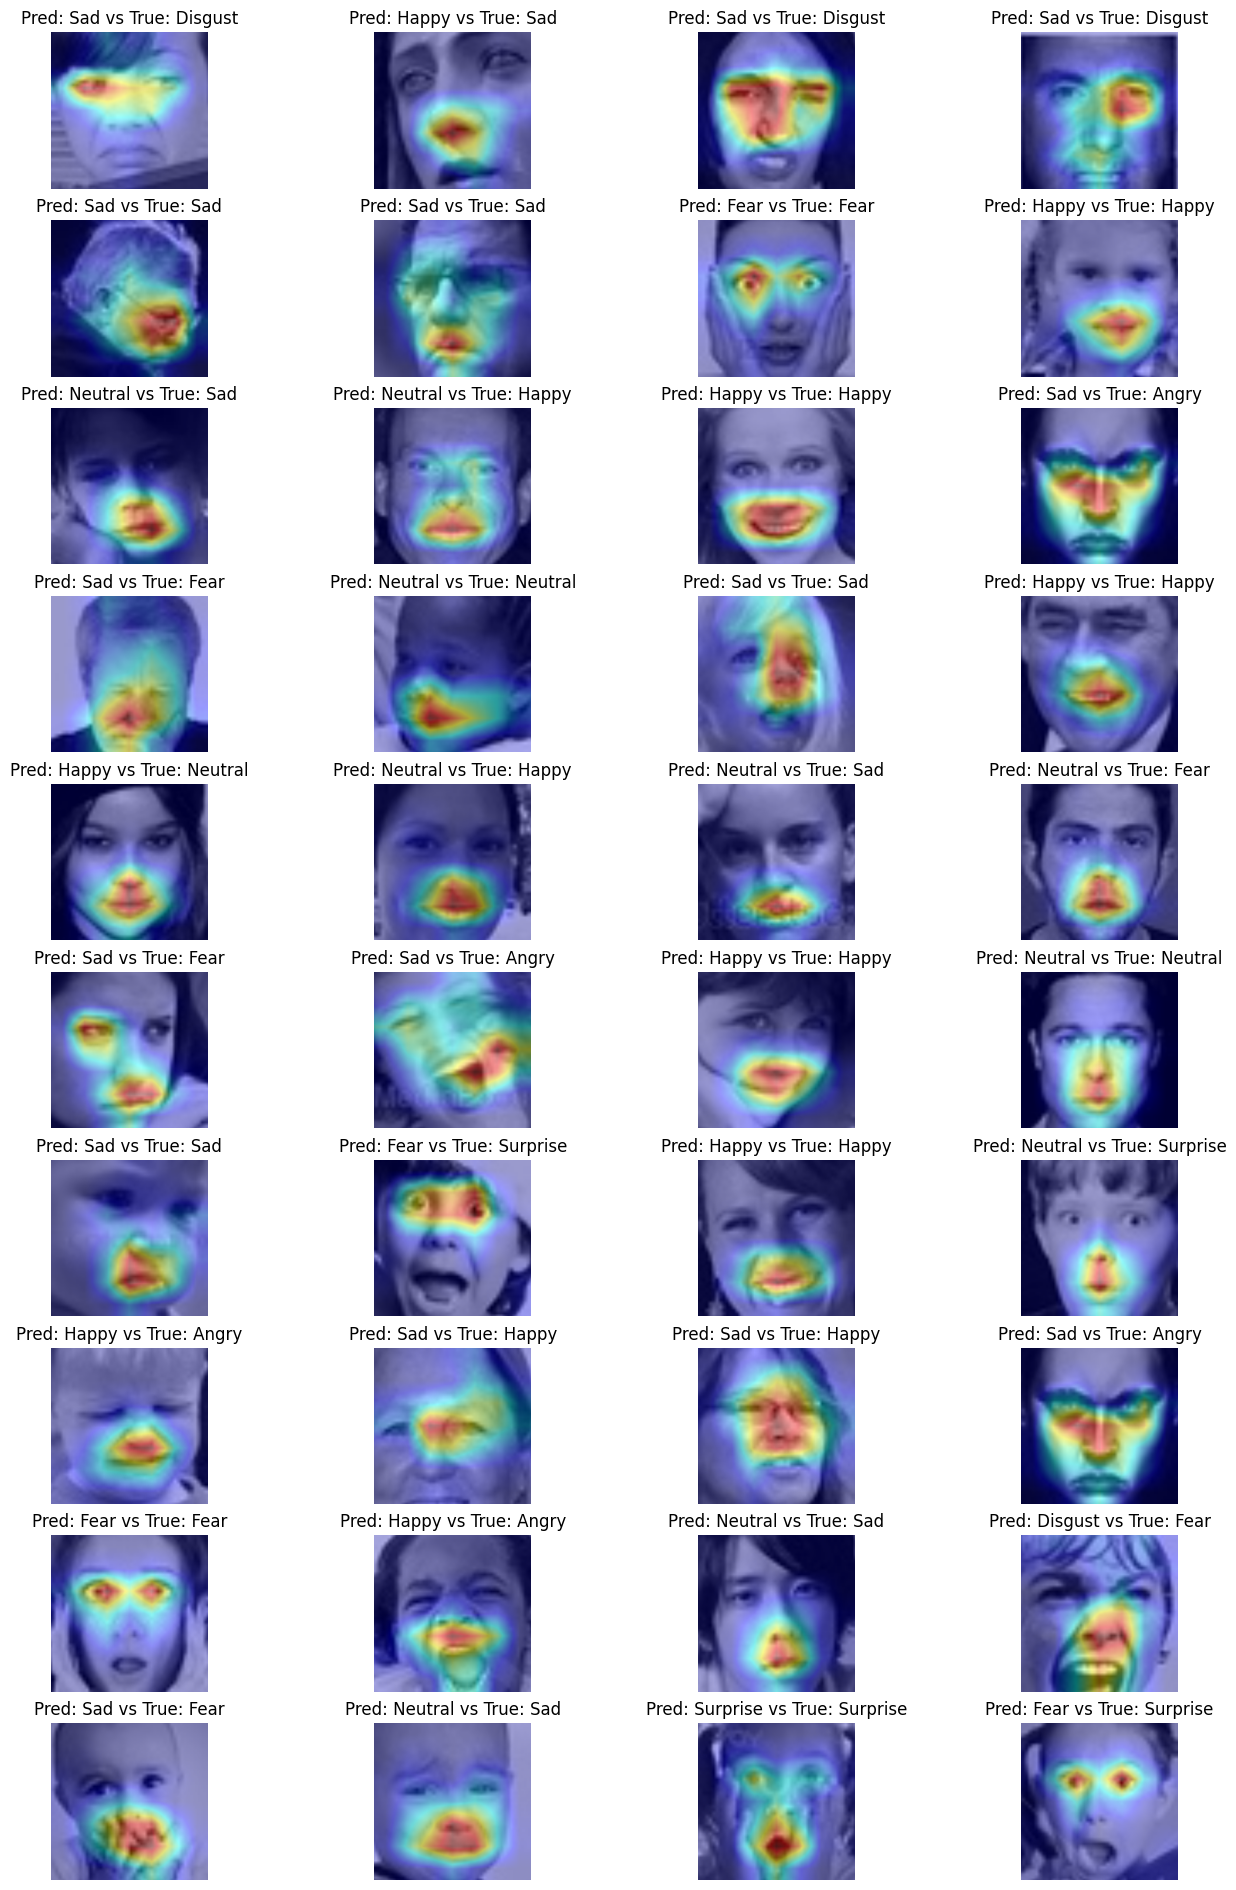

In [ ]:
figure = plt.figure(figsize=(16, 24))
cols, rows = 4, 10

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test), size=(1,)).item()
    img, label = test[sample_idx]
    img = invnorm_transform(img)
    viz, pred = create_gradCAM(trained_model_path, img)

    figure.add_subplot(rows, cols, i)
    plt.imshow(viz)
    plt.title("Pred: {} vs True: {}".format(labels_map[pred.item()], labels_map[label]))
    plt.axis("off")
plt.show()

## SqueezeNet Experiment

Define custom model class

In [ ]:
# create custom SqueezeNet
class CustomSqueezeNet(torch.nn.Module):
    def __init__(self, num_classes, ori_net):
        super(CustomSqueezeNet, self).__init__()
        self.features = torch.nn.Sequential(*list(ori_net.children())[:-1])
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            torch.nn.Conv2d(512, num_classes, kernel_size=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x,1)

mod_name = '/squeeze_net_11'
model = build_model(mod_name)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 96.6MB/s]


Load data

In [ ]:
resize = 256
crop = 224

train_transform, test_transform, invnorm_transform = setup_transformation(resize = resize,
                                                                          crop = crop,
                                                                          mean = mean,
                                                                          std = std)

train, val, test, train_loader, val_loader, test_loader = load_data(data_dir,
                                                                    train_transform,
                                                                    test_transform,
                                                                    batch_size,
                                                                    num_workers)

In [ ]:
input = torch.randn(1, 3, crop, crop)
macs, params = profile(model, inputs=(input, ))
macs, params = clever_format([macs, params], "%.3f")
print(macs, params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
263.231M 726.087K


Retrain model from scratch (Using pre-trained weights as initialization point)

In [ ]:
lr = 0.0005
label_smoothing = 0.1
weight_decay=0.0002
num_epochs = 15

early_stopping = EarlyStopping(tolerance=15, min_delta=0)

criterion = torch.nn.CrossEntropyLoss(label_smoothing = label_smoothing)

optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay=weight_decay,
                            )

if torch.cuda.is_available():
    model, criterion = model.cuda(), criterion.cuda()

best_model = train_model(model, criterion, optimizer,train_loader, val_loader, num_epochs=num_epochs)

Training Epoch 1/15
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: loss:1.830
Epoch 1: loss:1.729
Epoch 1: loss:1.816
Epoch 1: loss:1.815
Epoch 1: loss:1.738
Epoch 1: loss:1.876
Train loss: 1.8000, Train Acc: 0.2801, Val loss: 1.6370, Val Acc: 0.3931
Training Epoch 2/15
----------
Epoch 2: loss:1.427
Epoch 2: loss:1.444
Epoch 2: loss:1.596
Epoch 2: loss:1.511
Epoch 2: loss:1.548
Epoch 2: loss:1.596
Train loss: 1.5455, Train Acc: 0.4487, Val loss: 1.4803, Val Acc: 0.4756
Training Epoch 3/15
----------
Epoch 3: loss:1.556
Epoch 3: loss:1.430
Epoch 3: loss:1.377
Epoch 3: loss:1.359
Epoch 3: loss:1.543
Epoch 3: loss:1.771
Train loss: 1.4593, Train Acc: 0.4945, Val loss: 1.3804, Val Acc: 0.5447
Training Epoch 4/15
----------
Epoch 4: loss:1.449
Epoch 4: loss:1.313
Epoch 4: loss:1.513
Epoch 4: loss:1.353
Epoch 4: loss:1.496
Epoch 4: loss:0.818
Train loss: 1.4020, Train Acc: 0.5250, Val loss: 1.4182, Val Acc: 0.5219
Training Epoch 5/15
----------
Epoch 5: loss:1.377
Epoch 5: loss:1.532
Epoch 5: loss:1.394
Epoch 5: loss:1.333
Epoch 5: loss:1.308
Epoc

Evaluate on test subset

In [ ]:
trained_model_path = "/content/squeeze_net_11_20240502_0624.pth"
# trained_model_path = "D:/Downloads/model/squeeze_net_11_20240502_0624.pth"

print('-' * 10)
print('Test Accuracy:')

model = torch.load(trained_model_path,
                   map_location=torch.device(device)
                   )

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()
outPre, outLabel = test_model(model, criterion, test, test_loader)

----------
Test Accuracy:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss: 1.1094 Acc: 0.5837


Confusion Matrix

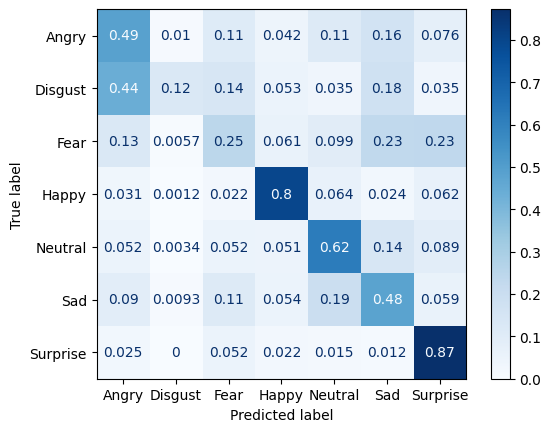

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel, outPre, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report

In [ ]:
report = sklearn.metrics.classification_report(outLabel,
                                               outPre,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.53      0.49      0.51       497
     Disgust       0.29      0.12      0.17        57
        Fear       0.38      0.25      0.30       526
       Happy       0.84      0.80      0.82       869
     Neutral       0.55      0.62      0.58       593
         Sad       0.49      0.48      0.49       645
    Surprise       0.53      0.87      0.66       402

    accuracy                           0.58      3589
   macro avg       0.52      0.52      0.50      3589
weighted avg       0.58      0.58      0.57      3589



GradCAM Analysis

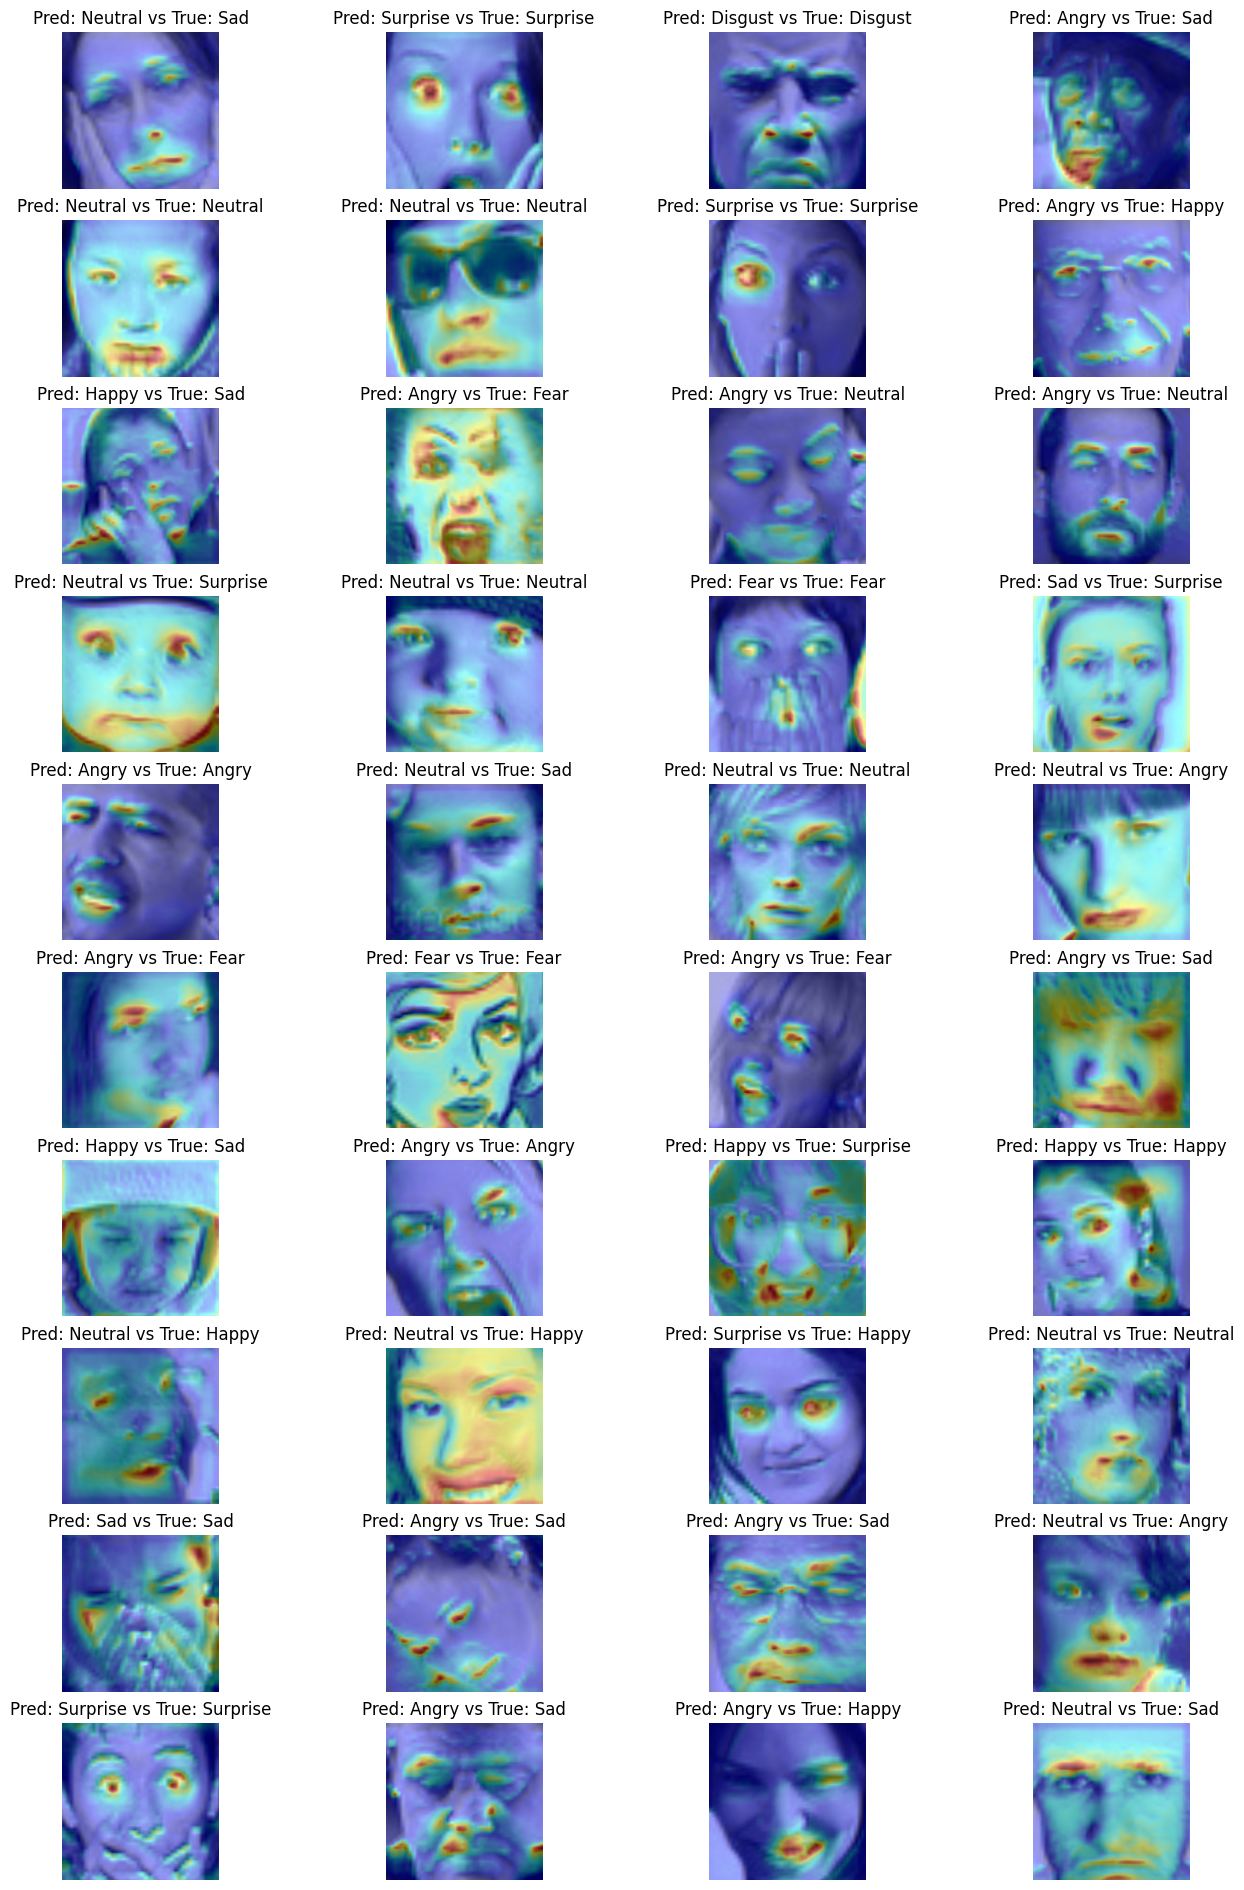

In [ ]:
figure = plt.figure(figsize=(16, 24))
cols, rows = 4, 10

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test), size=(1,)).item()
    img, label = test[sample_idx]
    img = invnorm_transform(img)
    viz, pred = create_gradCAM(trained_model_path, img)

    figure.add_subplot(rows, cols, i)
    plt.imshow(viz)
    plt.title("Pred: {} vs True: {}".format(labels_map[pred.item()], labels_map[label]))
    plt.axis("off")
plt.show()

## GradCAM Analysis of Smaller Models

In [ ]:
resize = 232
crop = 224

train_transform, test_transform, invnorm_transform = setup_transformation(resize = resize,
                                                                          crop = crop,
                                                                          mean = mean,
                                                                          std = std)

train, val, test, train_loader, val_loader, test_loader = load_data(data_dir,
                                                                    train_transform,
                                                                    test_transform,
                                                                    batch_size,
                                                                    num_workers)

In [ ]:
trained_model_path_shuffle = "/content/model/shuffle_net_v2_x2_0_20240429_0946.pth"
# trained_model_path_shuffle = "D:/Downloads/model/shuffle_net_v2_x2_0_20240429_0946.pth"


trained_model_path_mobile = "/content/model/mobile_net_v3l_20240429_1217.pth"
# trained_model_path_mobile = "D:/Downloads/model/mobile_net_v3l_20240429_1217.pth"


trained_model_path_squeeze = "/content/model/squeeze_net_11_20240502_0624.pth"
# trained_model_path_squeeze = "D:/Downloads/model/squeeze_net_11_20240502_0624.pth"

trained_model_paths = [trained_model_path_shuffle, trained_model_path_mobile, trained_model_path_squeeze]

In [ ]:
n_examples = 50
pool_examples = {i: [] for i in range(num_classes)}

# Collect examples from the test dataset
for x, i in test:
    if all([len(ex) == n_examples for ex in pool_examples.values()]):
        break
    if len(pool_examples[i]) < n_examples:
        pool_examples[i].append(x)

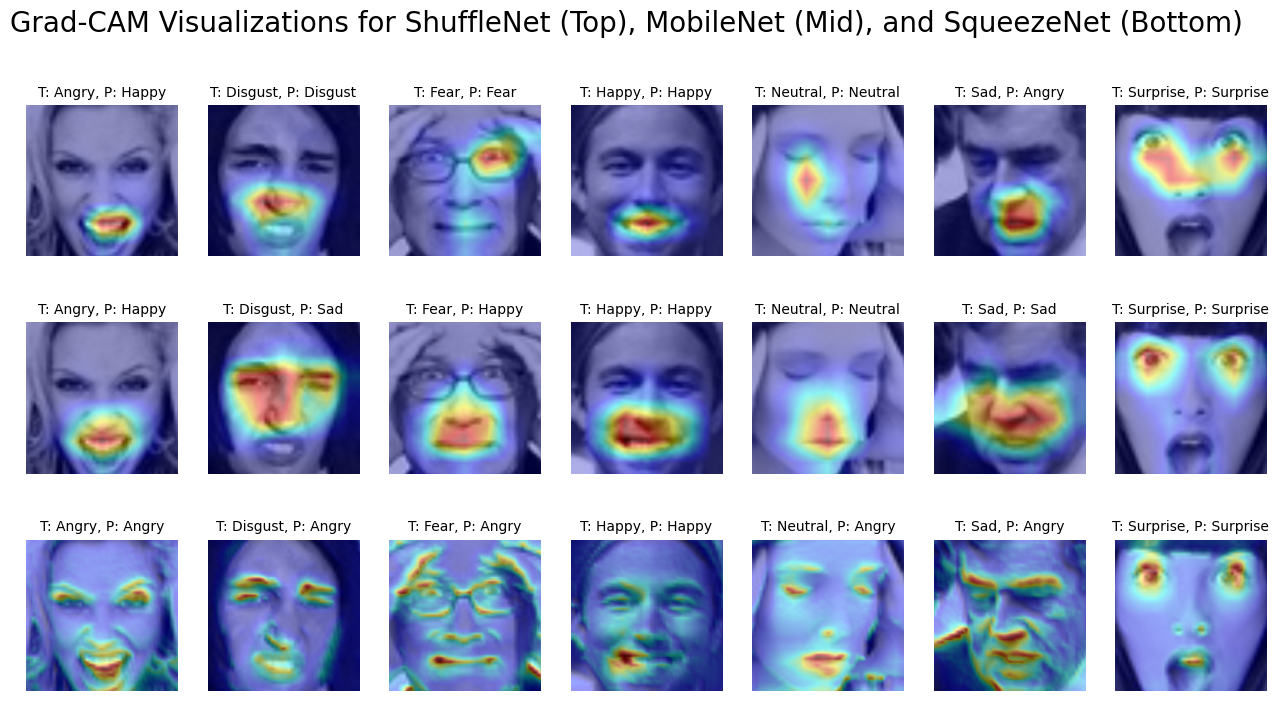

In [ ]:
examples = {0: pool_examples[0][0],
            1: pool_examples[1][4],
            2: pool_examples[2][42],
            3: pool_examples[3][1],
            4: pool_examples[4][0],
            5: pool_examples[5][1],
            6: pool_examples[6][0],
            }

n_examples = 1
figure = plt.figure(figsize=(16, 8))
cols, rows = num_classes, len(trained_model_paths)
figure.suptitle('Grad-CAM Visualizations for ShuffleNet (Top), MobileNet (Mid), and SqueezeNet (Bottom)', fontsize=20)

for row in range(rows):
    trained_model_path = trained_model_paths[row]
    for col in range(cols):
        for ex_idx in range(n_examples):
            img_idx = row * num_classes * n_examples + col * n_examples + ex_idx
            img = examples[col]
            img = invnorm_transform(img)

            viz, pred = create_gradCAM(trained_model_path, img)

            ax = figure.add_subplot(rows, cols * n_examples, img_idx + 1)
            ax.imshow(viz)
            ax.set_title(f"T: {labels_map[col]}, P: {labels_map[pred.item()]}", fontsize=10)
            ax.axis("off")
plt.show()

# One vs Rest Binary Classifiers

In [ ]:
class_freqs = [3995, 436, 4097, 7215, 4965, 4830, 3171]

In [ ]:
resize = 232
crop = 224

train_transform, test_transform, invnorm_transform = setup_transformation(resize = resize,
                                                                          crop = crop,
                                                                          mean = mean,
                                                                          std = std)

train, val, test, train_loader, val_loader, test_loader = load_data(data_dir,
                                                                    train_transform,
                                                                    test_transform,
                                                                    batch_size,
                                                                    num_workers)

## ShuffleNet for Fear
It has both the highest recall and F1 on 'Fear' thus could be interpreted as the most sensitive to this expression

In [ ]:
labels_map = {
    0: "Others",
    1: "Fear",
}

num_classes = len(labels_map)

mod_name = '/shuffle_net_v2_x2_0_binary_fear'
model = build_model(mod_name)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:00<00:00, 166MB/s]


In [ ]:
model

CustomShuffleNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(12

Retrain model from scratch (Using pre-trained weights as initialization point)

In [ ]:
lr = 0.0001
label_smoothing = 0.1
weight_decay=0.01
num_epochs = 15
binary = 2

early_stopping = EarlyStopping(tolerance=15, min_delta=0)

weights = torch.tensor([1/20000, 1/4097])
criterion = torch.nn.CrossEntropyLoss(weight = weights, label_smoothing = label_smoothing)

optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay=weight_decay,
                            )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode = 'max',
                                                       patience = 5
                                                        )

if torch.cuda.is_available():
    model, criterion = model.cuda(), criterion.cuda()

best_model = train_model(model, criterion, optimizer, scheduler, early_stopping,train_loader, val_loader, num_epochs=num_epochs, binary = binary)

Training Epoch 1/15
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: loss:0.741
Epoch 1: loss:0.771
Epoch 1: loss:0.773
Epoch 1: loss:0.680
Epoch 1: loss:0.705
Epoch 1: loss:0.868
Train loss: 0.7182, Train Acc: 0.6071, Val loss: 0.7226, Val Acc: 0.5001
Training Epoch 2/15
----------
Epoch 2: loss:0.665
Epoch 2: loss:0.784
Epoch 2: loss:0.693
Epoch 2: loss:0.747
Epoch 2: loss:0.659
Epoch 2: loss:0.486
Train loss: 0.6821, Train Acc: 0.6858, Val loss: 0.7017, Val Acc: 0.5899
Training Epoch 3/15
----------
Epoch 3: loss:0.592
Epoch 3: loss:0.683
Epoch 3: loss:0.705
Epoch 3: loss:0.626
Epoch 3: loss:0.708
Epoch 3: loss:0.733
Train loss: 0.6652, Train Acc: 0.7033, Val loss: 0.7228, Val Acc: 0.7601
Training Epoch 4/15
----------
Epoch 4: loss:0.634
Epoch 4: loss:0.709
Epoch 4: loss:0.777
Epoch 4: loss:0.741
Epoch 4: loss:0.715
Epoch 4: loss:0.577
Train loss: 0.6581, Train Acc: 0.7151, Val loss: 0.7200, Val Acc: 0.7420
Training Epoch 5/15
----------
Epoch 5: loss:0.692
Epoch 5: loss:0.713
Epoch 5: loss:0.671
Epoch 5: loss:0.723
Epoch 5: loss:0.619
Epoc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training complete in 19m 41s


Evaluate on test subset

In [ ]:
trained_model_path = "/content/model/shuffle_net_v2_x2_0_binary_fear_20240520_1616.pth"
# trained_model_path = "D:/Downloads/model/shuffle_net_v2_x2_0_binary_fear_20240520_1616.pth"
binary = 2

print('-' * 10)
print('Test Accuracy:')

model = torch.load(trained_model_path,
                   map_location=torch.device(device)
                   )

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()
outPre, outLabel = test_model(model, criterion, test, test_loader, binary = binary)

----------
Test Accuracy:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss: 0.5397 Acc: 0.7818


Confusion Matrix

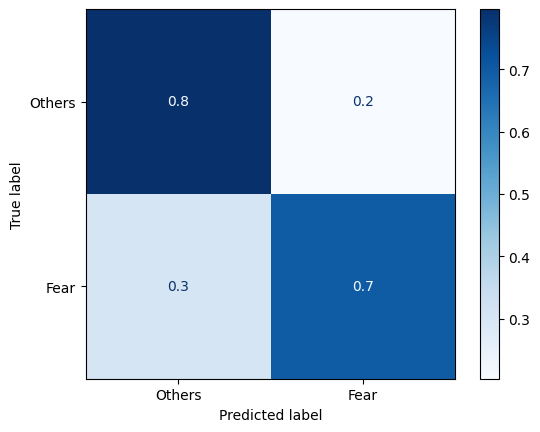

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel, outPre, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report

In [ ]:
report = sklearn.metrics.classification_report(outLabel,
                                               outPre,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

      Others       0.94      0.80      0.86      3063
        Fear       0.37      0.70      0.48       526

    accuracy                           0.78      3589
   macro avg       0.65      0.75      0.67      3589
weighted avg       0.86      0.78      0.81      3589



## ShuffleNet for Disgust
It has both the highest recall and F1 on 'Disgust' thus could be interpreted as the most sensitive to this expression

In [ ]:
labels_map = {
    0: "Others",
    1: "Disgust",
}

num_classes = len(labels_map)

mod_name = '/shuffle_net_v2_x2_0_binary_disgust'
model = build_model(mod_name)

In [ ]:
lr = 0.0001
label_smoothing = 0.1
weight_decay=0.01
num_epochs = 15
binary = 1

early_stopping = EarlyStopping(tolerance=15, min_delta=0)

weights = torch.tensor([1/(7500), 1/500])
criterion = torch.nn.CrossEntropyLoss(weight = weights, label_smoothing = label_smoothing)

optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay=weight_decay,
                            )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode = 'max',
                                                       patience = 5
                                                        )

if torch.cuda.is_available():
    model, criterion = model.cuda(), criterion.cuda()

best_model = train_model(model, criterion, optimizer, scheduler, early_stopping,train_loader, val_loader, num_epochs=num_epochs, binary = binary)

Training Epoch 1/15
----------
Epoch 1: loss:1.182
Epoch 1: loss:1.054
Epoch 1: loss:0.887
Epoch 1: loss:1.197
Epoch 1: loss:1.188
Epoch 1: loss:1.182
Train loss: 1.0626, Train Acc: 0.8449, Val loss: 1.0646, Val Acc: 0.8941
Training Epoch 2/15
----------
Epoch 2: loss:1.025
Epoch 2: loss:1.178
Epoch 2: loss:1.182
Epoch 2: loss:1.178
Epoch 2: loss:1.199
Epoch 2: loss:1.177
Train loss: 1.0674, Train Acc: 0.8386, Val loss: 1.0566, Val Acc: 0.8598
Training Epoch 3/15
----------
Epoch 3: loss:0.793
Epoch 3: loss:0.878
Epoch 3: loss:1.181
Epoch 3: loss:1.040
Epoch 3: loss:0.865
Epoch 3: loss:1.177
Train loss: 1.0613, Train Acc: 0.8243, Val loss: 1.0692, Val Acc: 0.8267
Training Epoch 4/15
----------
Epoch 4: loss:1.193
Epoch 4: loss:1.183
Epoch 4: loss:1.184
Epoch 4: loss:1.059
Epoch 4: loss:1.189
Epoch 4: loss:1.186
Train loss: 1.0708, Train Acc: 0.8559, Val loss: 1.0632, Val Acc: 0.9067
Training Epoch 5/15
----------
Epoch 5: loss:1.184
Epoch 5: loss:0.990
Epoch 5: loss:1.187
Epoch 5: loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training complete in 19m 46s


Evaluate on test subset

In [ ]:
trained_model_path = "/content/fer2013/shuffle_net_v2_x2_0_binary_disgust_20240521_0559.pth"
# trained_model_path = "D:/Downloads/model/shuffle_net_v2_x2_0_binary_disgust_20240521_0559.pth"
binary = 1

print('-' * 10)
print('Test Accuracy:')

model = torch.load(trained_model_path,
                   map_location=torch.device(device)
                   )

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()
outPre, outLabel = test_model(model, criterion, test, test_loader, binary = binary)

----------
Test Accuracy:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss: 0.6588 Acc: 0.8782


Confusion Matrix

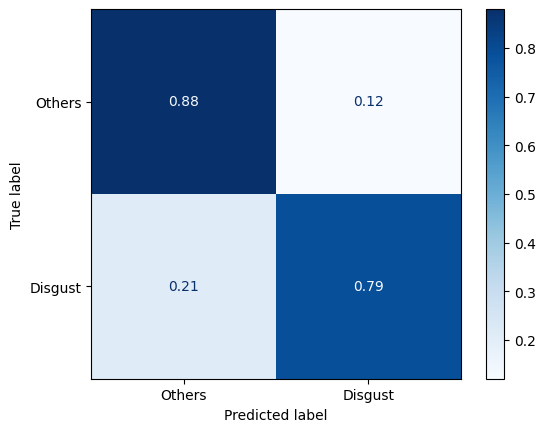

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel, outPre, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report

In [ ]:
report = sklearn.metrics.classification_report(outLabel,
                                               outPre,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

      Others       1.00      0.88      0.93      3532
     Disgust       0.10      0.79      0.17        57

    accuracy                           0.88      3589
   macro avg       0.55      0.83      0.55      3589
weighted avg       0.98      0.88      0.92      3589



## MobileNet for Sad
It has both the highest recall and F1 on 'Sad' thus could be interpreted as the most sensitive to this expression

In [ ]:
labels_map = {
    0: "Others",
    1: "Sad",
}

num_classes = len(labels_map)

mod_name = '/mobile_net_v3l_binary_sad'
model = build_model(mod_name)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 49.9MB/s]


In [ ]:
lr = 0.0001
label_smoothing = 0.1
weight_decay=0.01
num_epochs = 15
binary = 5

early_stopping = EarlyStopping(tolerance=15, min_delta=0)

weights = torch.tensor([1/(20000), 1/4830])
criterion = torch.nn.CrossEntropyLoss(weight = weights, label_smoothing = label_smoothing)

optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay=weight_decay,
                            )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode = 'max',
                                                       patience = 5
                                                        )

if torch.cuda.is_available():
    model, criterion = model.cuda(), criterion.cuda()

best_model = train_model(model, criterion, optimizer, scheduler, early_stopping,train_loader, val_loader, num_epochs=num_epochs, binary = binary)

Training Epoch 1/15
----------
Epoch 1: loss:0.666
Epoch 1: loss:0.750
Epoch 1: loss:0.721
Epoch 1: loss:0.659
Epoch 1: loss:0.675
Epoch 1: loss:0.946
Train loss: 0.6908, Train Acc: 0.6389, Val loss: 0.7189, Val Acc: 0.3433
Training Epoch 2/15
----------
Epoch 2: loss:0.583
Epoch 2: loss:0.677
Epoch 2: loss:0.617
Epoch 2: loss:0.614
Epoch 2: loss:0.539
Epoch 2: loss:0.443
Train loss: 0.6544, Train Acc: 0.6712, Val loss: 0.6999, Val Acc: 0.4283
Training Epoch 3/15
----------
Epoch 3: loss:0.684
Epoch 3: loss:0.784
Epoch 3: loss:0.671
Epoch 3: loss:0.599
Epoch 3: loss:0.569
Epoch 3: loss:0.905
Train loss: 0.6377, Train Acc: 0.6992, Val loss: 0.7089, Val Acc: 0.4040
Training Epoch 4/15
----------
Epoch 4: loss:0.588
Epoch 4: loss:0.678
Epoch 4: loss:0.676
Epoch 4: loss:0.766
Epoch 4: loss:0.580
Epoch 4: loss:0.874
Train loss: 0.6393, Train Acc: 0.7028, Val loss: 0.7071, Val Acc: 0.3926
Training Epoch 5/15
----------
Epoch 5: loss:0.573
Epoch 5: loss:0.647
Epoch 5: loss:0.555
Epoch 5: loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training complete in 19m 35s


Evaluate on test subset

In [ ]:
trained_model_path = "/content/model/mobile_net_v3l_binary_sad_20240520_1716.pth"
# trained_model_path = "D:/Downloads/model/mobile_net_v3l_binary_sad_20240520_1716.pth"
binary = 5

print('-' * 10)
print('Test Accuracy:')

model = torch.load(trained_model_path,
                   map_location=torch.device(device)
                   )

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()
outPre, outLabel = test_model(model, criterion, test, test_loader, binary = binary)

----------
Test Accuracy:


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loss: 0.6262 Acc: 0.6751


Confusion Matrix

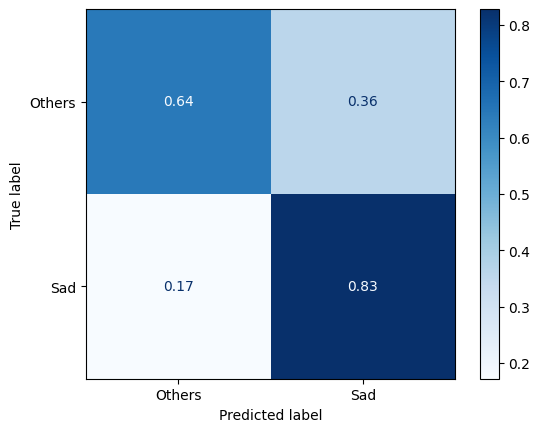

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel, outPre, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report

In [ ]:
report = sklearn.metrics.classification_report(outLabel,
                                               outPre,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

      Others       0.94      0.64      0.76      2944
         Sad       0.34      0.83      0.48       645

    accuracy                           0.68      3589
   macro avg       0.64      0.73      0.62      3589
weighted avg       0.84      0.68      0.71      3589



# Ensembling Predictions

In [ ]:
resize = 232
crop = 224

train_transform, test_transform, invnorm_transform = setup_transformation(resize = resize,
                                                                          crop = crop,
                                                                          mean = mean,
                                                                          std = std)

train, val, test, train_loader, val_loader, test_loader = load_data(data_dir,
                                                                    train_transform,
                                                                    test_transform,
                                                                    batch_size,
                                                                    num_workers)

In [ ]:
trained_model_path_shuff = "/content/model/shuffle_net_v2_x2_0_20240429_0946.pth"
# trained_model_path = "D:/Downloads/model/shuffle_net_v2_x2_0_20240429_0946.pth"

model_shuffle = torch.load(trained_model_path_shuff,
                   map_location=torch.device(device)
                   )


trained_model_path_mob = "/content/model/mobile_net_v3l_20240429_1217.pth"
# trained_model_path = "D:/Downloads/model/mobile_net_v3l_20240429_1217.pth"

model_mob = torch.load(trained_model_path_mob,
                   map_location=torch.device(device)
                   )


trained_model_path_sque = "/content/model/squeeze_net_11_20240502_0624.pth"
# trained_model_path = "D:/Downloads/model/mobile_net_v3l_20240429_1217.pth"

model_squeeze = torch.load(trained_model_path_sque,
                   map_location=torch.device(device)
                   )


trained_model_path_fear = "/content/model/shuffle_net_v2_x2_0_binary_fear_20240520_1616.pth"
# trained_model_path = "D:/Downloads/model/shuffle_net_v2_x2_0_binary_fear_20240520_1616.pth"
binary_fear = 2

model_fear = torch.load(trained_model_path_fear,
                   map_location=torch.device(device)
                   )


trained_model_path_disgust = "/content/model/shuffle_net_v2_x2_0_binary_disgust_20240521_0559.pth"
# trained_model_path = "D:/Downloads/model/shuffle_net_v2_x2_0_binary_disgust_20240521_0559.pth"
binary_disgust = 1

model_disgust = torch.load(trained_model_path_disgust,
                   map_location=torch.device(device)
                   )


trained_model_path_sad = "/content/model/mobile_net_v3l_binary_sad_20240520_1716.pth"
# trained_model_path = "D:/Downloads/model/mobile_net_v3l_binary_sad_20240520_1716.pth"
binary_sad = 5

model_sad = torch.load(trained_model_path_sad,
                   map_location=torch.device(device)
                   )

## Majority Vote
1. Use the mostly voted class as prediction
2. If there is a tie, choose the one with higher prediction confidence

In [ ]:
binary_fear = 2
binary_disgust = 1
binary_sad = 5

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model_shuffle, model_mob, model_squeeze, model_fear, model_disgust, model_sad, criterion = model_shuffle.cuda(), model_mob.cuda(), model_squeeze.cuda(), model_fear.cuda(), model_disgust.cuda(), model_sad.cuda(), criterion.cuda()

# outPre_shuffle_train, outLabel_train, conf_shuffle_train = test_model(model_shuffle, criterion, train, train_loader, binary = None, conf = True)
# outPre_mob_train, _, conf_mob_train = test_model(model_mob, criterion, train, train_loader, binary = None, conf = True)
# outPre_squeeze_train, _, conf_squeeze_train = test_model(model_squeeze, criterion, train, train_loader, binary = None, conf = True)
# outPre_fear_train, _, conf_fear_train = test_model(model_fear, criterion, train, train_loader, binary = binary_fear, conf = True)
# outPre_disgust_train, _, conf_disgust_train = test_model(model_disgust, criterion, train, train_loader, binary = binary_disgust, conf = True)
# outPre_sad_train, _, conf_sad_train = test_model(model_sad, criterion, train, train_loader, binary = binary_sad, conf = True)

outPre_shuffle_val, outLabel_val, conf_shuffle_val = test_model(model_shuffle, criterion, val, val_loader, binary = None, conf = True)
outPre_mob_val, _, conf_mob_val = test_model(model_mob, criterion, val, val_loader, binary = None, conf = True)
outPre_squeeze_val, _, conf_squeeze_val = test_model(model_squeeze, criterion, val, val_loader, binary = None, conf = True)
outPre_fear_val, _, conf_fear_val = test_model(model_fear, criterion, val, val_loader, binary = binary_fear, conf = True)
outPre_disgust_val, _, conf_disgust_val = test_model(model_disgust, criterion, val, val_loader, binary = binary_disgust, conf = True)
outPre_sad_val, _, conf_sad_val = test_model(model_sad, criterion, val, val_loader, binary = binary_sad, conf = True)

outPre_shuffle_test, outLabel_test, conf_shuffle_test = test_model(model_shuffle, criterion, test, test_loader, binary = None, conf = True)
outPre_mob_test, _, conf_mob_test = test_model(model_mob, criterion, test, test_loader, binary = None, conf = True)
outPre_squeeze_test, _, conf_squeeze_test = test_model(model_squeeze, criterion, test, test_loader, binary = None, conf = True)
outPre_fear_test, _, conf_fear_test = test_model(model_fear, criterion, test, test_loader, binary = binary_fear, conf = True)
outPre_disgust_test, _, conf_disgust_test = test_model(model_disgust, criterion, test, test_loader, binary = binary_disgust, conf = True)
outPre_sad_test, _, conf_sad_test = test_model(model_sad, criterion, test, test_loader, binary = binary_sad, conf = True)

# outPre_fear_train = torch.tensor([binary_fear if i == 1 else 0 for i in outPre_fear_train])
# outPre_disgust_train = torch.tensor([binary_disgust if i == 1 else 0 for i in outPre_disgust_train])
# outPre_sad_train = torch.tensor([binary_sad if i == 1 else 0 for i in outPre_sad_train])

outPre_fear_val = torch.tensor([binary_fear if i == 1 else 0 for i in outPre_fear_val])
outPre_disgust_val = torch.tensor([binary_disgust if i == 1 else 0 for i in outPre_disgust_val])
outPre_sad_val = torch.tensor([binary_sad if i == 1 else 0 for i in outPre_sad_val])

outPre_fear_test = torch.tensor([binary_fear if i == 1 else 0 for i in outPre_fear_test])
outPre_disgust_test = torch.tensor([binary_disgust if i == 1 else 0 for i in outPre_disgust_test])
outPre_sad_test = torch.tensor([binary_sad if i == 1 else 0 for i in outPre_sad_test])

Loss: 0.9419 Acc: 0.6612
Loss: 0.9951 Acc: 0.6523
Loss: 1.0877 Acc: 0.5938
Loss: 0.5349 Acc: 0.7802
Loss: 0.6546 Acc: 0.8821
Loss: 0.6219 Acc: 0.6815
Loss: 0.9642 Acc: 0.6570
Loss: 0.9967 Acc: 0.6498
Loss: 1.1138 Acc: 0.5821
Loss: 0.5398 Acc: 0.7818
Loss: 0.6588 Acc: 0.8782
Loss: 0.6261 Acc: 0.6754


In [ ]:
def ensemble_binary(outPre_mob, outPre_fear, outPre_disgust, outPre_sad, conf_mob, conf_fear, conf_disgust, conf_sad):
    preds = torch.stack([outPre_mob, outPre_fear, outPre_disgust, outPre_sad], dim = 1)
    confs = torch.stack([conf_mob, conf_fear, conf_disgust, conf_sad], dim = 1)

    ens_pred_binary = []
    for i in range(len(outPre_mob)):
        ens = preds[i][:1].reshape(1)
        ens_conf = confs[i][:1].reshape(1)

        for j in range(1, 4):
            if preds[i][j] > 0:
                ens = torch.cat((ens, preds[i][j].reshape(1)))
                ens_conf = torch.cat((ens_conf, confs[i][j].reshape(1)))

        ens_pred_binary.append(ens[torch.argmax(ens_conf, dim = 0).item()].item())

    return ens_pred_binary

def ensemble_small(outPre_shuffle, outPre_mob, outPre_squeeze, conf_shuffle, conf_mob, conf_squeeze):
    preds = torch.stack([outPre_shuffle, outPre_mob, outPre_squeeze], dim = 1)
    confs = torch.stack([conf_shuffle, conf_mob, conf_squeeze], dim = 1)

    ens_pred_small = []
    for i in range(len(outPre_shuffle)):
        sample_preds = preds[i]
        sample_confs = confs[i]
        mode, count = torch.mode(sample_preds)
        # ens_pred_small.append(mode.item())
        max_count = count.item()

        # Find all predictions that have the max count
        possible_modes = sample_preds[sample_preds == mode]

        if len(possible_modes) == 1:
            # No tie, use the mode
            ens_pred_small.append(mode.item())
        else:
            # Tie exists, select the class with the highest confidence
            max_conf = -1
            best_class = None
            for m in possible_modes:
                m_indices = (sample_preds == m).nonzero(as_tuple=True)[0]
                m_conf = sample_confs[m_indices].max().item()
                if m_conf > max_conf:
                    max_conf = m_conf
                    best_class = m.item()
            ens_pred_small.append(best_class)

    return ens_pred_small

### Ensemble with binary classifiers
Mobile (multi-class), shuffle (fear), shuffle (disgust), mobile (sad)

In [ ]:
ens_pred_binary = ensemble_binary(outPre_mob_test, outPre_fear_test, outPre_disgust_test, outPre_sad_test, conf_mob_test, conf_fear_test, conf_disgust_test, conf_sad_test)

Confusion Matrix for Majority Voting Ensemble (w Binary)

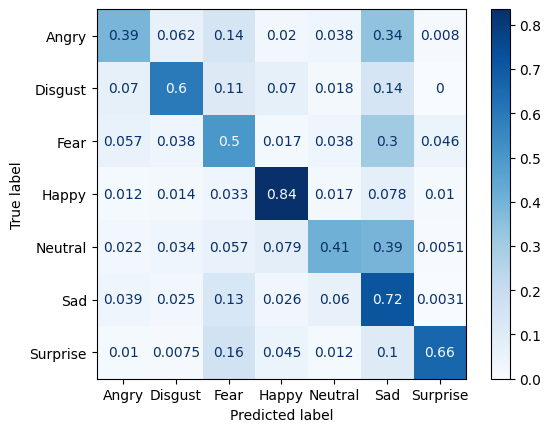

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel_test, ens_pred_binary, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report for Majority Voting Ensemble (w Binary)

In [ ]:
report = sklearn.metrics.classification_report(outLabel_test,
                                               ens_pred_binary,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.69      0.39      0.50       497
     Disgust       0.25      0.60      0.35        57
        Fear       0.48      0.50      0.49       526
       Happy       0.87      0.84      0.85       869
     Neutral       0.71      0.41      0.52       593
         Sad       0.41      0.72      0.52       645
    Surprise       0.86      0.66      0.75       402

    accuracy                           0.61      3589
   macro avg       0.61      0.59      0.57      3589
weighted avg       0.67      0.61      0.62      3589



In [ ]:
print(sklearn.metrics.accuracy_score(outLabel_test, ens_pred_binary))
print(sklearn.metrics.f1_score(outLabel_test, ens_pred_binary,
                               average = 'weighted'
                               ))

0.6099191975480636
0.6161198511032024


### Ensemble with all multi-class classifiers
ShuffleNet, MobileNet, SqueezeNet

In [ ]:
ens_pred_small = ensemble_small(outPre_shuffle_test, outPre_mob_test, outPre_squeeze_test, conf_shuffle_test, conf_mob_test, conf_squeeze_test)

Confusion Matrix for Majority Voting Ensemble (All-Multi)

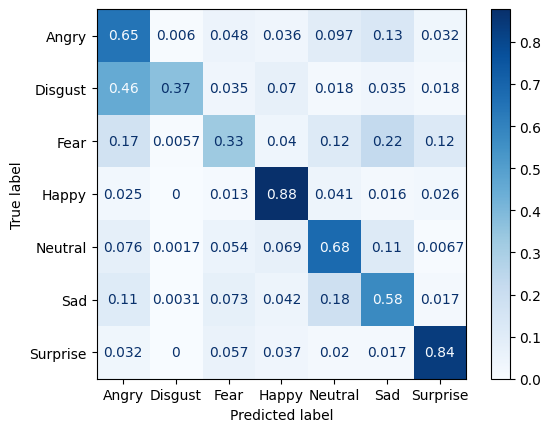

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel_test, ens_pred_small, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report for Majority Voting Ensemble (All-Multi)

In [ ]:
report = sklearn.metrics.classification_report(outLabel_test,
                                               ens_pred_small,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.55      0.65      0.60       497
     Disgust       0.70      0.37      0.48        57
        Fear       0.55      0.33      0.41       526
       Happy       0.86      0.88      0.87       869
     Neutral       0.60      0.68      0.64       593
         Sad       0.58      0.58      0.58       645
    Surprise       0.74      0.84      0.79       402

    accuracy                           0.67      3589
   macro avg       0.65      0.62      0.62      3589
weighted avg       0.66      0.67      0.66      3589



In [ ]:
print(sklearn.metrics.accuracy_score(outLabel_test, ens_pred_small))
print(sklearn.metrics.f1_score(outLabel_test, ens_pred_small,
                               average = 'weighted'
                               ))

0.6656450264697688
0.6571825850328782


## Averaging probabilities

In [ ]:
def get_model_outputs(test_loader, binary, model):
    all_outputs = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            if binary is not None:
                labels = torch.tensor([1 if i.item() == binary else 0 for i in labels])
            labels = torch.squeeze(labels.type(torch.LongTensor))
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            outputs = torch.nn.functional.softmax(outputs, dim=1)
            if binary is not None:
                outputs = torch.squeeze(outputs)
                predictions = (outputs[:, 1] > outputs[:, 0]).long()
                final_outputs = []
                for i, prediction in enumerate(predictions):
                    if prediction == 1:
                        tmp = [0, 0, 0, 0, 0, 0, 0]
                        tmp[binary] = outputs[i, 1].item()  # Save the probability instead of 1
                        final_outputs.append(tmp)
                    else:
                        final_outputs.append([0, 0, 0, 0, 0, 0, 0])
                outputs = torch.tensor(final_outputs, device=outputs.device).float()
            all_outputs.append(outputs)
            all_labels.append(labels)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_outputs, all_labels

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = (preds == labels).sum().item()
    accuracy = corrects / len(labels)
    return accuracy

def gather_all_model_outputs(test_loader):
    shuffle_outputs, shuffle_labels = get_model_outputs(test_loader, None, model_shuffle)
    mob_outputs, mob_labels = get_model_outputs(test_loader, None, model_mob)
    squeeze_outputs, squeeze_labels = get_model_outputs(test_loader, None, model_squeeze)
    fear_outputs, fear_labels = get_model_outputs(test_loader, binary_fear, model_fear)
    disgust_outputs, disgust_labels = get_model_outputs(test_loader, binary_disgust, model_disgust)
    sad_outputs, sad_labels = get_model_outputs(test_loader, binary_sad, model_sad)

    return (shuffle_outputs, mob_outputs, squeeze_outputs, fear_outputs, disgust_outputs, sad_outputs), shuffle_labels

def average_outputs(outputs, weighted = False, weight = None):
    if weighted:
        outputs = weight*outputs
    avg_output = torch.sum(outputs, dim = 1) / outputs.shape[1]
    return avg_output

In [ ]:
binary_fear = 2
binary_disgust = 1
binary_sad = 5

criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model_shuffle, model_mob, model_squeeze, model_fear, model_disgust, model_sad, criterion = model_shuffle.cuda(), model_mob.cuda(), model_squeeze.cuda(), model_fear.cuda(), model_disgust.cuda(), model_sad.cuda(), criterion.cuda()

all_outputs, labels = gather_all_model_outputs(test_loader)
shuffle_outputs, mob_outputs, squeeze_outputs, fear_outputs, disgust_outputs, sad_outputs = all_outputs

In [ ]:
idx = 1111

print(shuffle_outputs[idx])
print(mob_outputs[idx])
print(squeeze_outputs[idx])
print(fear_outputs[idx])
print(disgust_outputs[idx])
print(sad_outputs[idx])

tensor([0.0227, 0.0067, 0.7312, 0.0119, 0.0106, 0.0291, 0.1878],
       device='cuda:0')
tensor([0.0297, 0.0079, 0.6698, 0.0107, 0.0110, 0.1959, 0.0751],
       device='cuda:0')
tensor([0.0497, 0.0142, 0.3173, 0.0159, 0.0209, 0.0596, 0.5224],
       device='cuda:0')
tensor([0.0000, 0.0000, 0.9629, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


### Simple Averaging

In [ ]:
ensemble_binary_outputs = torch.stack([mob_outputs, fear_outputs, disgust_outputs, sad_outputs], dim = 1)
ensemble_multi_outputs = torch.stack([shuffle_outputs, mob_outputs, squeeze_outputs], dim = 1)

avg_output_binary = average_outputs(ensemble_binary_outputs)
accuracy_binary = calculate_accuracy(avg_output_binary, labels)

avg_output_multi = average_outputs(ensemble_multi_outputs)
accuracy_multi = calculate_accuracy(avg_output_multi, labels)

print(f'Accuracy with Binary Ensemble: {accuracy_binary * 100:.2f}%')
print(f'Accuracy with All-Multi Ensemble: {accuracy_multi * 100:.2f}%')

Accuracy with Binary Ensemble: 60.30%
Accuracy with All-Multi Ensemble: 67.01%


#### Ensemble with binary classifiers
Mobile (multi-class), shuffle (fear), shuffle (disgust), mobile (sad)

Confusion Matrix for Avg. Ensemble (w Binary)

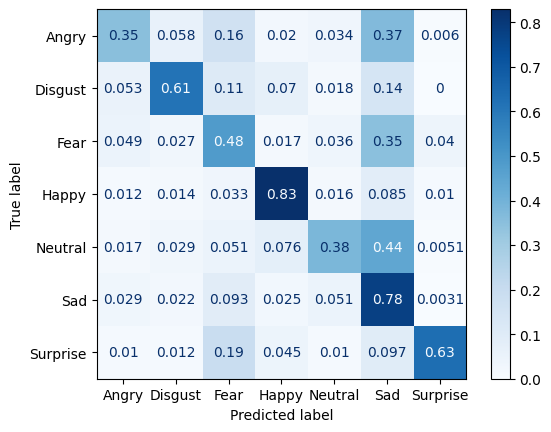

In [ ]:
_, preds = torch.max(avg_output_binary, 1)

cm = sklearn.metrics.confusion_matrix(labels.detach().cpu().numpy(),
                                      preds.detach().cpu().numpy(),
                                      normalize= 'true',
                                      labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report for Avg. Ensemble (w Binary)

In [ ]:
report = sklearn.metrics.classification_report(labels.detach().cpu().numpy(),
                                               preds.detach().cpu().numpy(),
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.71      0.35      0.47       497
     Disgust       0.28      0.61      0.38        57
        Fear       0.47      0.48      0.48       526
       Happy       0.88      0.83      0.85       869
     Neutral       0.72      0.38      0.50       593
         Sad       0.40      0.78      0.53       645
    Surprise       0.87      0.63      0.73       402

    accuracy                           0.60      3589
   macro avg       0.62      0.58      0.56      3589
weighted avg       0.67      0.60      0.61      3589



In [ ]:
print(sklearn.metrics.accuracy_score(labels.detach().cpu().numpy(),
                                     preds.detach().cpu().numpy(),))
print(sklearn.metrics.f1_score(labels.detach().cpu().numpy(),
                               preds.detach().cpu().numpy(),
                               average = 'weighted'
                               ))

0.6029534689328504
0.606357315155754


#### Ensemble with all multi-class classifiers
ShuffleNet, MobileNet, SqueezeNet

Confusion Matrix for Avg. Ensemble (All-Multi)

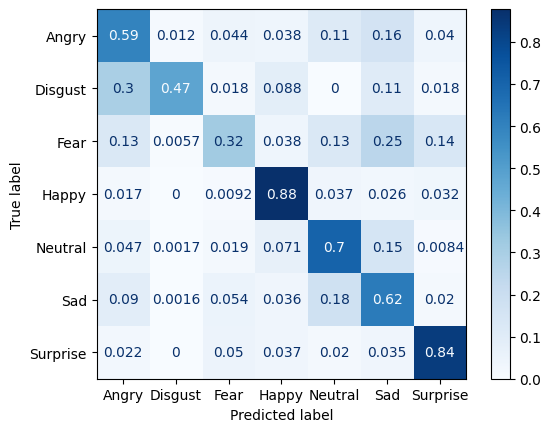

In [ ]:
_, preds = torch.max(avg_output_multi, 1)

cm = sklearn.metrics.confusion_matrix(labels.detach().cpu().numpy(),
                                      preds.detach().cpu().numpy(),
                                      normalize= 'true',
                                      labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report for Avg. Ensemble (All-Multi)

In [ ]:
report = sklearn.metrics.classification_report(labels.detach().cpu().numpy(),
                                               preds.detach().cpu().numpy(),
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.60      0.59      0.60       497
     Disgust       0.71      0.47      0.57        57
        Fear       0.63      0.32      0.42       526
       Happy       0.86      0.88      0.87       869
     Neutral       0.60      0.70      0.65       593
         Sad       0.54      0.62      0.58       645
    Surprise       0.71      0.84      0.77       402

    accuracy                           0.67      3589
   macro avg       0.66      0.63      0.64      3589
weighted avg       0.67      0.67      0.66      3589



In [ ]:
print(sklearn.metrics.accuracy_score(labels.detach().cpu().numpy(),
                                     preds.detach().cpu().numpy(),))
print(sklearn.metrics.f1_score(labels.detach().cpu().numpy(),
                               preds.detach().cpu().numpy(),
                               average = 'weighted'
                               ))

0.6701030927835051
0.6607212127776659


### Weighted Averaging
* for binary ensemble (Mobile, Fear, Disgust, Sad):
  * backbone multi-class model = 40% on every class
  * specialized binary model = 60% on specialized class, 0 on other

* for all-multi ensemble (Efficient, Mobile, Shuffle):
  * Highest recall model on each class = 40%
  * others = 30% each (60% total)

In [ ]:
weight_mob = torch.tensor([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])
weight_fear = torch.tensor([0., 0., 0.6, 0., 0., 0., 0.])
weight_disgust = torch.tensor([0., 0.6, 0., 0., 0., 0., 0.])
weight_sad = torch.tensor([0., 0., 0., 0., 0., 0.6, 0.])

weights_binary = torch.stack([weight_mob, weight_fear, weight_disgust, weight_sad], dim = 0).to(device)

weight_shuffle = torch.tensor([0.3, 0.4, 0.4, 0.3, 0.4, 0.3, 0.3])        #According to accuracy/recall
weight_mob = torch.tensor([0.4, 0.3, 0.3, 0.4, 0.3, 0.4, 0.3])            #According to acc/recall
weight_squeeze = torch.tensor([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4])        #According to acc/recall

weights_multi = torch.stack([weight_shuffle, weight_mob, weight_squeeze], dim = 0).to(device)

In [ ]:
ensemble_binary_outputs = torch.stack([mob_outputs, fear_outputs, disgust_outputs, sad_outputs], dim = 1)
ensemble_multi_outputs = torch.stack([shuffle_outputs, mob_outputs, squeeze_outputs], dim = 1)

weighted_avg_output_binary = average_outputs(ensemble_binary_outputs, weighted = True, weight = weights_binary)
weighted_accuracy_binary = calculate_accuracy(weighted_avg_output_binary, labels)

weighted_avg_output_multi = average_outputs(ensemble_multi_outputs, weighted = True, weight = weights_multi)
weighted_accuracy_multi = calculate_accuracy(weighted_avg_output_multi, labels)

print(f'Accuracy with Binary Ensemble (Weighted): {weighted_accuracy_binary * 100:.2f}%')
print(f'Accuracy with All-Multi Ensemble (Weighted): {weighted_accuracy_multi * 100:.2f}%')

Accuracy with Binary Ensemble (Weighted): 56.03%
Accuracy with All-Multi Ensemble (Weighted): 66.95%


#### Ensemble with binary classifiers
Mobile (multi-class), shuffle (fear), shuffle (disgust), mobile (sad)

Confusion Matrix for Weighted Avg. Ensemble (w Binary)

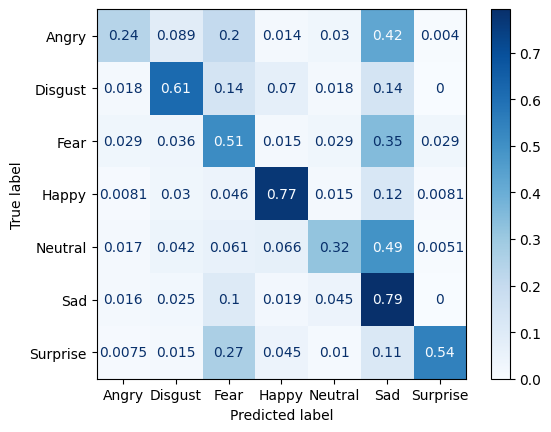

In [ ]:
_, preds = torch.max(weighted_avg_output_binary, 1)

cm = sklearn.metrics.confusion_matrix(labels.detach().cpu().numpy(),
                                      preds.detach().cpu().numpy(),
                                      normalize= 'true',
                                      labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report for Weighted Avg. Ensemble (w Binary)

In [ ]:
report = sklearn.metrics.classification_report(labels.detach().cpu().numpy(),
                                               preds.detach().cpu().numpy(),
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.72      0.24      0.36       497
     Disgust       0.20      0.61      0.31        57
        Fear       0.43      0.51      0.47       526
       Happy       0.88      0.77      0.82       869
     Neutral       0.71      0.32      0.44       593
         Sad       0.38      0.79      0.51       645
    Surprise       0.89      0.54      0.68       402

    accuracy                           0.56      3589
   macro avg       0.60      0.54      0.51      3589
weighted avg       0.66      0.56      0.56      3589



In [ ]:
print(sklearn.metrics.accuracy_score(labels.detach().cpu().numpy(),
                                     preds.detach().cpu().numpy(),))
print(sklearn.metrics.f1_score(labels.detach().cpu().numpy(),
                               preds.detach().cpu().numpy(),
                               average = 'weighted'
                               ))

0.5603232098077459
0.5621342224299373


#### Ensemble with all multi-class classifiers
ShuffleNet, MobileNet, SqueezeNet

Confusion Matrix for Weighted Avg. Ensemble (All-Multi)

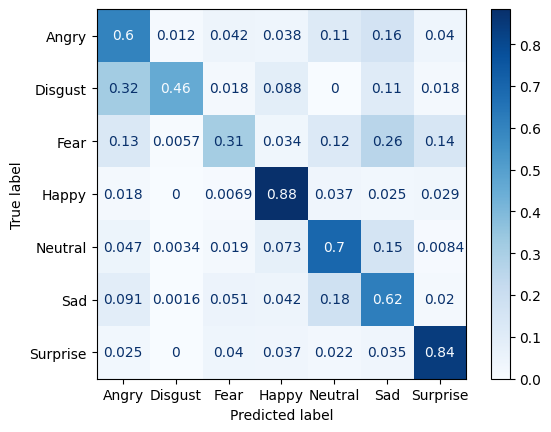

In [ ]:
_, preds = torch.max(weighted_avg_output_multi, 1)

cm = sklearn.metrics.confusion_matrix(labels.detach().cpu().numpy(),
                                      preds.detach().cpu().numpy(),
                                      normalize= 'true',
                                      labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report for Weighted Avg. Ensemble (All-Multi)

In [ ]:
report = sklearn.metrics.classification_report(labels.detach().cpu().numpy(),
                                               preds.detach().cpu().numpy(),
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.60      0.60      0.60       497
     Disgust       0.68      0.46      0.55        57
        Fear       0.65      0.31      0.42       526
       Happy       0.86      0.88      0.87       869
     Neutral       0.60      0.70      0.65       593
         Sad       0.53      0.62      0.57       645
    Surprise       0.71      0.84      0.77       402

    accuracy                           0.67      3589
   macro avg       0.66      0.63      0.63      3589
weighted avg       0.67      0.67      0.66      3589



In [ ]:
print(sklearn.metrics.accuracy_score(labels.detach().cpu().numpy(),
                                     preds.detach().cpu().numpy(),))
print(sklearn.metrics.f1_score(labels.detach().cpu().numpy(),
                               preds.detach().cpu().numpy(),
                               average = 'weighted'
                               ))

0.6695458344942881
0.6596710815511209


In [ ]:
weight_shuffle = torch.tensor([0.51, 0.54, 0.4, 0.86, 0.73, 0.55, 0.82])        #According to accuracy/recall
weight_mob = torch.tensor([0.61, 0.3, 0.28, 0.9, 0.59, 0.66, 0.76])            #According to acc/recall
weight_squeeze = torch.tensor([0.49, 0.12, 0.25, 0.8, 0.62, 0.48, 0.87])        #According to acc/recall

weights_multi = torch.stack([weight_shuffle, weight_mob, weight_squeeze], dim = 0).to(device)

In [ ]:
ensemble_multi_outputs = torch.stack([shuffle_outputs, mob_outputs, squeeze_outputs], dim = 1)
weighted_avg_output_multi = average_outputs(ensemble_multi_outputs, weighted = True, weight = weights_multi)
weighted_accuracy_multi = calculate_accuracy(weighted_avg_output_multi, labels)
print(f'Accuracy with All-Multi Ensemble (Weighted): {weighted_accuracy_multi * 100:.2f}%')

Accuracy with All-Multi Ensemble (Weighted): 65.42%


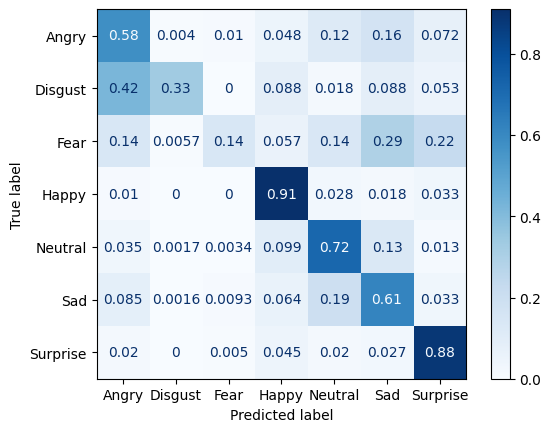

In [ ]:
_, preds = torch.max(weighted_avg_output_multi, 1)

cm = sklearn.metrics.confusion_matrix(labels.detach().cpu().numpy(),
                                      preds.detach().cpu().numpy(),
                                      normalize= 'true',
                                      labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report for Weighted Avg. Ensemble (All-Multi)

In [ ]:
report = sklearn.metrics.classification_report(labels.detach().cpu().numpy(),
                                               preds.detach().cpu().numpy(),
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.60      0.58      0.59       497
     Disgust       0.73      0.33      0.46        57
        Fear       0.83      0.14      0.24       526
       Happy       0.82      0.91      0.86       869
     Neutral       0.59      0.72      0.65       593
         Sad       0.53      0.61      0.57       645
    Surprise       0.62      0.88      0.73       402

    accuracy                           0.65      3589
   macro avg       0.68      0.60      0.59      3589
weighted avg       0.68      0.65      0.62      3589



In [ ]:
print(sklearn.metrics.accuracy_score(labels.detach().cpu().numpy(),
                                     preds.detach().cpu().numpy(),))
print(sklearn.metrics.f1_score(labels.detach().cpu().numpy(),
                               preds.detach().cpu().numpy(),
                               average = 'weighted'
                               ))

0.6542212315408191
0.6245941015687253


# Large Models for Benchmark

## Larger EfficientNet (B3) Experiment

Define custom model class

In [ ]:
# create custom efficientnet
class CustomEfficientNet(torch.nn.Module):
    def __init__(self, num_classes, ori_net):
        super(CustomEfficientNet, self).__init__()
        self.features = torch.nn.Sequential(*list(ori_net.features.children()))
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.classifier = torch.nn.Sequential(
            *[list(ori_net.classifier.children())[i] for i in [0]],
            torch.nn.Linear(1536, num_classes, bias = True),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x


mod_name = '/efficient_net_b3'
model = build_model(mod_name)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 79.9MB/s]


In [ ]:
model

CustomEfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNor

Load data

In [ ]:
resize = 320
crop = 300


train_transform, test_transform, invnorm_transform = setup_transformation(resize = resize,
                                                                          crop = crop,
                                                                          mean = mean,
                                                                          std = std)

train, val, test, train_loader, val_loader, test_loader = load_data(data_dir,
                                                                    train_transform,
                                                                    test_transform,
                                                                    batch_size,
                                                                    num_workers)

In [ ]:
input = torch.randn(1, 3, crop, crop)
macs, params = profile(model, inputs=(input, ))
macs, params = clever_format([macs, params], "%.3f")
print(macs, params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
1.930G 10.707M


Retrain model from scratch (Using pre-trained weights as initialization point)

In [ ]:
lr = 0.0001
label_smoothing = 0.1
weight_decay=0.005
num_epochs = 15

early_stopping = EarlyStopping(tolerance=15, min_delta=0)

criterion = torch.nn.CrossEntropyLoss(label_smoothing = label_smoothing)

optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay=weight_decay,
                            )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode = 'max',
                                                       patience = 5
                                                        )

if torch.cuda.is_available():
    model, criterion = model.cuda(), criterion.cuda()

best_model = train_model(model, criterion, optimizer, scheduler, early_stopping, train_loader, val_loader, num_epochs=num_epochs)

Evaluate on test subset

In [ ]:
trained_model_path = "/content/model/efficient_net_b3_20240509_0149.pth"
# trained_model_path = "D:/Downloads/model/efficient_net_b3_20240509_0149.pth"

print('-' * 10)
print('Test Accuracy:')

model = torch.load(trained_model_path,
                   map_location=torch.device(device)
                   )
criterion = torch.nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()
outPre, outLabel = test_model(model, criterion, test, test_loader)

----------
Test Accuracy:
Loss: 0.8905 Acc: 0.6863


Confusion Matrix

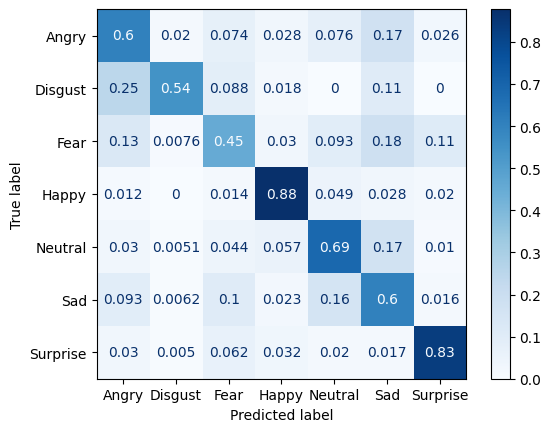

In [ ]:
cm = sklearn.metrics.confusion_matrix(outLabel, outPre, normalize= 'true', labels = list(labels_map.keys()))
sklearn.metrics.ConfusionMatrixDisplay(cm,  display_labels = list(labels_map.values())).plot(cmap=plt.cm.Blues)

Classification Metrics Report

In [ ]:
report = sklearn.metrics.classification_report(outLabel,
                                               outPre,
                                               labels= list(labels_map.keys()),
                                               target_names= list(labels_map.values())
                                              )

print(report)

              precision    recall  f1-score   support

       Angry       0.62      0.60      0.61       497
     Disgust       0.57      0.54      0.56        57
        Fear       0.58      0.45      0.51       526
       Happy       0.89      0.88      0.88       869
     Neutral       0.63      0.69      0.66       593
         Sad       0.55      0.60      0.58       645
    Surprise       0.77      0.83      0.80       402

    accuracy                           0.69      3589
   macro avg       0.66      0.66      0.66      3589
weighted avg       0.68      0.69      0.68      3589



In [ ]:
print(sklearn.metrics.accuracy_score(outLabel,
                                     outPre))
print(sklearn.metrics.f1_score(outLabel,
                               outPre,
                               average = 'weighted'
                               ))

0.6862635831707997
0.6841144780741228
